# Evaluation of GRN inference methods
## Explanatory analysis
### by Jalil Nourisa



# Imports

In [1]:
%reload_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


import tqdm
import json
import warnings
import matplotlib
import sys
import requests
import seaborn as sns
from scipy.stats import spearmanr
# import gseapy as gp
import scanpy as sc 
from scipy.sparse import csr_matrix
from pandas.api.types import CategoricalDtype
category_order_reg1 = CategoricalDtype(categories=['GRNBoost2', 'Scenic+', 'Positive Ctrl', 'Pearson Corr.', 'GRaNIE'], ordered=True)
category_order_reg2 = CategoricalDtype(categories=['GRNBoost2', 'Positive Ctrl', 'Pearson Corr.', 'PPCOR'], ordered=True)

palette_datasets = sns.color_palette('Set3', 7)[2:]

# from mplfonts import use_font

sys.path.append('../../')
from grn_benchmark.src.helper import surragate_names, custom_jointplot, colors_cell_type, color_map_methods, all_models, datasets, color_map_datasets
from task_grn_inference.src.utils.util import colors_blind
from task_grn_inference.src.exp_analysis.helper import *

color_map_methods = {surragate_names[name]:value for name, value in color_map_methods.items()}
controls3 = ['Dabrafenib', 'Belinostat', 'Dimethyl Sulfoxide']

task_grn_inference_dir = '../../task_grn_inference'
results_folder = f'{task_grn_inference_dir}/resources/results'
figs_dir = f'{results_folder}/figs'
os.makedirs(figs_dir, exist_ok=True)
perturb_col = 'perturbation'

# plt.rcParams['font.family'] = 'Liberation Sans'
plt.rcParams['font.family'] = 'Arial'
default_font = matplotlib.rcParams['font.family']
print(default_font)

def binarize_weight(weight):
    if weight > 0:
        return 1
    elif weight < 0:
        return -1
    else:
        return 0

all_models = [surragate_names.get(name,name) for name in all_models]


# colors_methods = {name: colors_blind[i] for i, name in enumerate(['Baseline Correlation', 'Positive Control', 'GRaNIE', 'GRNBoost2', 'PPCOR', 'Scenic+'])} 

# Assign each method a different linestyle
import itertools
line_styles = ['-', '--', '-.', ':']
linestyle_map_methods = {key: linestyle for key, linestyle in zip(all_models, itertools.cycle(line_styles))}


%matplotlib inline

['Arial']


# Dataset overview

In [76]:
n_target_genes_datasets = {} 
for dataset in datasets: 
    print(f'----inference {dataset}---')
    inference_dataset = ad.read_h5ad(f'{task_grn_inference_dir}/resources/inference_data/{dataset}_rna.h5ad')
    print('sample count: ', len(inference_dataset),'gene count: ', inference_dataset.var_names.nunique())
    if 'perturbation' in inference_dataset.obs:
        print('pertub count: ', inference_dataset.obs['perturbation'].nunique())

    print(f'----evaluation {dataset}---')
    perturbation_data = ad.read_h5ad(f'{task_grn_inference_dir}/resources/evaluation_data/{dataset}_perturbation.h5ad')
    n_target_genes_datasets[dataset] = perturbation_data.var_names.nunique()
    print('sample count: ', len(perturbation_data),'gene count: ', perturbation_data.var_names.nunique(), 'pertub count: ', perturbation_data.obs['perturbation'].nunique())

----inference op---
sample count:  25551 gene count:  22787
----evaluation op---
sample count:  2170 gene count:  15215 pertub count:  138
----inference replogle2---
sample count:  8869 gene count:  8244
pertub count:  7880
----evaluation replogle2---
sample count:  2072 gene count:  8244 pertub count:  2049
----inference nakatake---
sample count:  454 gene count:  25090
pertub count:  231
----evaluation nakatake---
sample count:  456 gene count:  25090 pertub count:  232
----inference norman---
sample count:  44710 gene count:  5045
pertub count:  116
----evaluation norman---
sample count:  115 gene count:  5035 pertub count:  115
----inference adamson---
sample count:  32223 gene count:  5060
pertub count:  17
----evaluation adamson---
sample count:  65 gene count:  5060 pertub count:  65


In [77]:
n_target_genes_datasets

{'op': 15215,
 'replogle2': 8244,
 'nakatake': 25090,
 'norman': 5035,
 'adamson': 5060}

In [78]:
# - perturbation strength 
def determine_fold_change_effect(adata, layer = 'X_norm'):
    results = []

    obs_all = adata.obs.reset_index(drop=True)
    X_all = adata.layers[layer]

    if 'cell_type' not in obs_all:
        obs_all['cell_type'] = 'celltype'
        
    for cell_type in obs_all.cell_type.unique():
        mask_celltype = obs_all.cell_type == cell_type

        obs = obs_all.loc[mask_celltype, :]
        X = X_all[mask_celltype, :]


        # - Compute absolute fold change for each gene compared to control group
        # control_indices = obs.index[obs['is_control']].tolist()
        control_matrix = X[obs['is_control'], :]
        control_mean_expression = np.mean(control_matrix, axis=0)
        control_std_expression = np.std(control_matrix, axis=1).mean()
        
        # - Group by unique perturbation samples
        for perturbation in obs['perturbation'].unique():
            group_indices = obs['perturbation']==perturbation
            sample_matrix = X[group_indices, :]  # Subset the gene expression data
            mean_expression = np.mean(sample_matrix, axis=0)  # Mean expression per gene for this sample
            std_expression = np.std(sample_matrix, axis=1).mean()  # Mean expression per gene for this sample
            # - calculate fold change
            mask = control_mean_expression != 0
            fold_change = (mean_expression[mask])/(control_mean_expression[mask])

            # - calulcate std 
            std_change = (std_expression)/(control_std_expression)

            # Store the results for each perturbation
            results.append({'perturbation': perturbation, 'Expression fold change': np.abs(fold_change).mean(), 'STD fold change': std_change, 'cell_type':cell_type})

    results = pd.DataFrame(results)

    return results

if False:
    perturbation_dict = {}
    for i, dataset in enumerate(datasets): 
        adata = ad.read_h5ad(f'{task_grn_inference_dir}/resources/datasets_raw/{dataset}_bulked.h5ad')
        print(dataset, ' number of perrutbation: ', adata.obs['perturbation'].nunique())
        perturbation_dict[dataset] = adata
        # - determine effect size
        perturb_effect_df = determine_fold_change_effect(adata)
        perturb_effect_df['Dataset'] = dataset
        perturb_effect_df['pertub_effect'] = round(np.std(adata.layers['X_norm'], axis=0).mean()/np.std(adata.layers['X_norm'], axis=1).mean(), 2)
        if i == 0:
            perturb_effect_all = perturb_effect_df
        else:
            perturb_effect_all = pd.concat([perturb_effect_all, perturb_effect_df], axis=0)
    perturb_effect_all.to_csv(f'{results_folder}/perturb_effect_all.csv')
else:
    perturb_effect_all = pd.read_csv(f'{results_folder}/perturb_effect_all.csv', index_col=0)


In [79]:
perturb_effect_all['Dataset'] = perturb_effect_all['Dataset'].map(lambda name: surragate_names.get(name,name))
# - set perturbation type 
perturb_effect_all['Perturbation type'] = perturb_effect_all['Dataset'].map({'OPSCA':'Chemical', 'Nakatake': 'Overexpression', 'Norman': 'Activation', 'Adamson':'KD', 'Replogle': 'KD'})

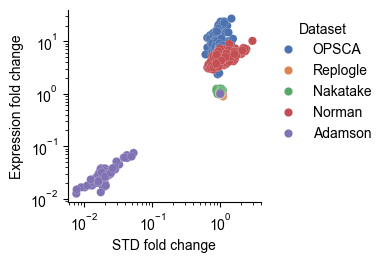

In [80]:
# - perturbation effect 
fig, ax = plt.subplots(1, 1, figsize=(2.5 , 2.5))
def plot_perturbation_strength_datasets(perturb_effect_all, ax):
    sns.scatterplot(perturb_effect_all, x='STD fold change', y='Expression fold change', hue='Dataset', alpha=1, ax=ax, linewidth=.1,edgecolor='white', palette={surragate_names[name]: color for name, color in color_map_datasets.items()})
    legend = ax.legend(bbox_to_anchor=(1, 1), frameon=False)
    legend.set_title("Dataset") 
    ax.set_yscale('log')
    ax.set_xscale('log')
    for side in ['right', 'top']:
        ax.spines[side].set_visible(False)
plot_perturbation_strength_datasets(perturb_effect_all, ax)
fig.savefig(f"{results_folder}/figs/perturbation_strength_datasets.png", dpi=300, transparent=True, bbox_inches='tight')

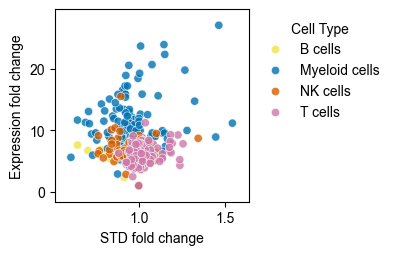

In [81]:
# - perturbation effect 
fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5))
def plot_perturbation_strength_celltypes(perturb_effect_all, ax):
    sns.scatterplot(perturb_effect_all[perturb_effect_all['Dataset']=='OPSCA'], x='STD fold change', y='Expression fold change', hue='cell_type', alpha=.8, ax=ax, palette=colors_blind[3:])
    legend = ax.legend(bbox_to_anchor=(1, 1), frameon=False)
    legend.set_title("Cell Type") 
    ax.margins(x=0.1, y=0.1)
    # for side in ['right', 'top']:
    #     ax.spines[side].set_visible(False)
    # ax.set_title(f"Perturbation strength", pad=10, fontsize=12, fontweight='bold')
plot_perturbation_strength_celltypes(perturb_effect_all, ax)
fig.savefig(f"{results_folder}/figs/perturbation_strength_celltypes.png", dpi=300, transparent=True, bbox_inches='tight')

In [82]:
if False:
    def plot_pertub_effect(adata, layer=None, ax=None, title=''):
        if layer is not None:
            adata.X = adata.layers[layer]
        try:
            y_true = adata.X.todense().A
        except:
            y_true = adata.X
        pertub_effect = round(np.std(y_true, axis=0).mean()/np.std(y_true, axis=1).mean(), 2)

        plot_cumulative_density(np.std(y_true, axis=0), ax=ax, label='std between samples', x_label='std')
        plot_cumulative_density(np.std(y_true, axis=1), ax=ax, label='std within samples',x_label='std')
        ax.set_title(f'{title}, pertub_effect= {pertub_effect:.2f}')

    fig, axes = plt.subplots(1, len(datasets), figsize=(4*len(datasets),3))
    for i, dataset in enumerate(datasets): 
        layer = 'X_norm'

        ax = axes[i]
        plot_pertub_effect(perturbation_dict[dataset], layer, ax, dataset)
    plt.legend()

# Format GRN models

In [83]:
if False: # granie extended grn
    net = pd.read_csv(f'{task_grn_inference_dir}/resources/grn_models/peak_gene/granie_extended.csv')
    net = net[['peak', 'gene']].drop_duplicates().reset_index(drop=True)
    net.columns = ['peak','target']
    net.to_csv(f'{task_grn_inference_dir}/resources/grn_models/peak_gene/granie.csv')
if False:  # scenicplus extended grn
    net = pd.read_csv(f'{task_grn_inference_dir}/output/scenicplus/grn_extended.csv', index_col=0)
    net = net[['peak', 'target']].drop_duplicates().reset_index(drop=True)
    net.to_csv(f'{task_grn_inference_dir}/resources/grn_models/peak_gene/scenicplus.csv')
if False: # figr extended grn
    net = pd.read_csv(f'{task_grn_inference_dir}/output/figr/cisCorr.csv', index_col=0)
    net = net[['PeakRanges', 'Gene']].drop_duplicates().reset_index(drop=True)
    net.columns = ['peak','target']
    net.to_csv(f'{task_grn_inference_dir}/resources/grn_models/peak_gene/figr.csv')

# Regression 2: consensus n regulators

In [84]:
thetas=['0', '0.5', '1']

In [85]:
def load_data(dataset, input_dir):
    """
    Load the JSON file for a given dataset and extract the data.
    """
    file_path = os.path.join(input_dir, 'resources/prior', f'regulators_consensus_{dataset}.json')
    with open(file_path, 'r') as f:
        data = json.load(f)
    gene_names = np.asarray(list(data.keys()), dtype=object)
    return data, gene_names

def process_features(data, gene_names, thetas):
    """
    Extract the number of features (regulators) for each theta value.
    """
    n_features = {
        theta: np.asarray([data[gene_name][theta] for gene_name in gene_names], dtype=int)
        for theta in thetas
    }
    return n_features

def plot_consensus_number_of_regulators(dataset, axes,thetas=['0', '0.5', '1'], color='#56B4E9'):
    """
    Create a plot for the consensus number of regulators for a dataset.
    """
    # Load and process data
    data, gene_names = load_data(dataset, task_grn_inference_dir)
    n_features = process_features(data, gene_names, thetas)
    
    
    for i, theta in enumerate(thetas):
        ax = axes[i]
        sns.histplot(
            data=n_features[theta], 
            ax=ax, 
            discrete=True, 
            color=color, 
            linewidth=.5, 
            edgecolor=None
        )
        ax.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='blue')
        for side in ['right', 'top']:
            ax.spines[side].set_visible(False)
        ax.set_yscale('log')
        ax.set_ylabel('Number of target genes')
        # ax.set_title(fr'$\theta$ = {theta}')
        if theta=='0':
            metric = "R2 (precision)"
        if theta=='0.5':
            metric = "R2 (balanced)"
        if theta=='1':
            metric = "R2 (recall)"
        ax.set_title(metric, pad=15, )
        ax.set_xlabel(r'Number of regulators')

    
    # output_path = os.path.join(output_dir, f"consensus_{dataset}.png")
    # fig.savefig(output_path, dpi=300, transparent=True, bbox_inches='tight')

def extract_nregulators_func(datasets, task_grn_inference_dir, results_folder, surrogate_names):
    """
    Analyze and plot the consensus number of regulators for a list of datasets.
    """
    n_genes_with_regulators_dict = {}

    for dataset in datasets:
        n_genes_with_regulators_dict[dataset] = []
        # Load and process data
        data, gene_names = load_data(dataset, task_grn_inference_dir)
        n_features = process_features(data, gene_names, thetas)

        # Calculate number of genes with at least one regulator for each theta
        for theta in thetas:
            n_genes_with_regulators_dict[dataset].append((n_features[theta] != 0).sum())
    return n_genes_with_regulators_dict

In [86]:
# - format it and store in one df
df_store = []
for dataset in datasets:
    data, gene_names = load_data(dataset, task_grn_inference_dir)
    n_features = process_features(data, gene_names, thetas)
    df = pd.DataFrame(n_features).melt(var_name='theta')
    df['dataset'] = dataset
    df_store.append(df)
regulatorys_consensus = pd.concat(df_store)
regulatorys_consensus['dataset'] = regulatorys_consensus['dataset'].map(surragate_names)
regulatorys_consensus['theta'] = regulatorys_consensus['theta'].map({'0':"R2 (precision)", '0.5':"R2 (balanced)", '1':"R2 (recall)"})
regulatorys_consensus['theta'].unique()

array(['R2 (precision)', 'R2 (balanced)', 'R2 (recall)'], dtype=object)

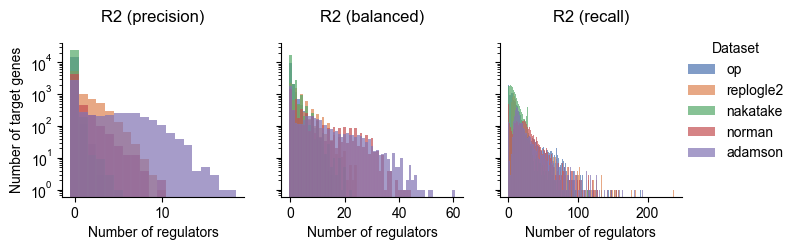

In [159]:
fig, axes = plt.subplots(1, 3, figsize=(8, 2), sharey=True)
for dataset in datasets:
    color=color_map_datasets[dataset]
    

    # Load and process data
    data, gene_names = load_data(dataset, task_grn_inference_dir)
    n_features = process_features(data, gene_names, thetas)
    
    
    for i, theta in enumerate(thetas):
        ax = axes[i]
        sns.histplot(
            alpha=.7,
            # edgecolor='black',
            data=n_features[theta], 
            ax=ax, 
            discrete=True, 
            color=color, 
            linewidth=.01, 
            edgecolor='white',
            label=dataset
        )
        # ax.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='blue')
        for side in ['right', 'top']:
            ax.spines[side].set_visible(False)
        ax.set_yscale('log')
        ax.set_ylabel('Number of target genes')
        # ax.set_title(fr'$\theta$ = {theta}')
        if theta=='0':
            metric = "R2 (precision)"
        if theta=='0.5':
            metric = "R2 (balanced)"
        if theta=='1':
            metric = "R2 (recall)"
        ax.set_title(metric, pad=15, )
        ax.set_xlabel(r'Number of regulators')
    # plt.savefig(f"{results_folder}/figs/nregulators_opsca.png", dpi=300, transparent=True, bbox_inches='tight')
    # plt.show()
plt.legend(loc=(1,.2), frameon=False, title='Dataset')
fig.savefig(f"{results_folder}/figs/consensus_regulators.png", dpi=300, transparent=True, bbox_inches='tight')



In [88]:
n_genes_with_regulators_dict = extract_nregulators_func(
    datasets=datasets,
    task_grn_inference_dir=task_grn_inference_dir,
    results_folder=results_folder,
    surrogate_names=surragate_names
)

/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_88372/2199906972.py:11: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.barplot(df, x='dataset', y='value', hue='index', palette=colors_blind[2:])


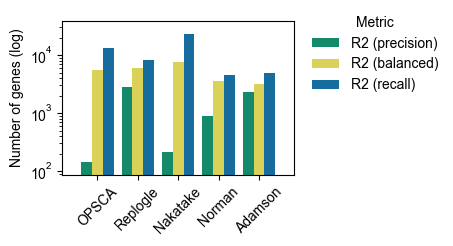

In [89]:
# Number of genes with actual regulators 
fig, ax = plt.subplots(1,1, figsize=(3, 2), sharey=True)
def plot_n_genes_with_regulators(n_genes_with_regulators_dict, ax):
    df = pd.DataFrame(n_genes_with_regulators_dict)
    df.index = ['static-theta-0.0', 'static-theta-0.5', 'static-theta-1.0']
    df.index = df.index.map(surragate_names)
    df.columns = df.columns.map(surragate_names)

    df = df.reset_index().melt(id_vars = 'index', var_name='dataset')
    df.index.name = 'Metric'
    sns.barplot(df, x='dataset', y='value', hue='index', palette=colors_blind[2:])
    # ax.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='blue')
    # for side in ['right', 'top']:
    #     ax.spines[side].set_visible(False)
    ax.margins(x=.1)
    ax.margins(y=.1)
    ax.set_yscale('log')
    # ax.set_xlabel(r'Number of selected regulators')
    ax.set_ylabel('Number of genes (log)')
    ax.set_xlabel(r'')
    # plt.title('Consensus genes with regulators', fontsize=12, fontweight='bold', pad=15)
    plt.legend(loc=(1.05, .5),frameon=False, title='Metric')
    plt.xticks(rotation=45)
plot_n_genes_with_regulators(n_genes_with_regulators_dict, ax)
fig.savefig(f"{results_folder}/figs/consensus_all.png", dpi=300, transparent=True, bbox_inches='tight')


# WS distance: consensus plot

In [90]:
consensus_store = []
for dataset in ['adamson', 'norman']:
    consensus = pd.read_csv(f'{task_grn_inference_dir}/resources/prior/ws_consensus_{dataset}.csv', index_col=0)
    consensus['dataset'] = dataset
    consensus_store.append(consensus)
consensus = pd.concat(consensus_store)
consensus['theta'] = consensus['theta'].map(surragate_names)
consensus.groupby(['dataset'])['source'].nunique()

dataset
adamson     8
norman     41
Name: source, dtype: int64

/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_88372/2033705944.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


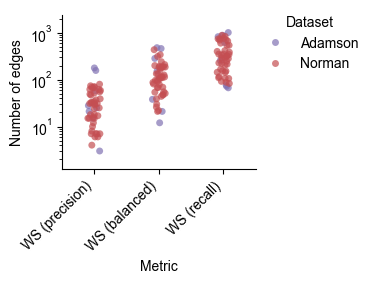

In [91]:
consensus['dataset'] = consensus['dataset'].map(surragate_names)

fig, ax = plt.subplots(1,1, figsize=(2.5, 2))
sns.stripplot(consensus, x='theta', y='value', hue='dataset',ax=ax, alpha=.7, edgecolor='black',
            palette={surragate_names[name]: color for name, color in color_map_datasets.items()})
plt.yscale('log')  
plt.xlabel('Metric')  
plt.ylabel('Number of edges') 
plt.margins(y=.15) 
plt.legend(loc=(1,.6), frameon=False, title='Dataset')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

fig.savefig(f"{results_folder}/figs/consensus_ws.png", dpi=300, transparent=True, bbox_inches='tight')

In [92]:
# ws_scores = pd.read_csv(f'{task_grn_inference_dir}/resources/scores/ws_distance.csv', index_col=0)
# sns.catplot(ws_scores, x='model', y='present_edges_n', col='theta', hue='dataset', kind='bar')

# Enrichment analysis on common TFs


In [93]:
# - reformat the genesets database
if False:
    panglao_df = pd.read_csv('../output/PanglaoDB_markers_27_Mar_2020.tsv.gz', sep='\t')

    panglao_df = panglao_df[panglao_df.species.isin(['Mm Hs','Hs'])]

    # Open a new file to write the GMT formatted data
    with open("../output/panglaodb_marker_sets.gmt", "w") as gmt_file:
        # Loop through each unique cell type in PanglaoDB
        for cell_type in panglao_df['cell type'].unique():
            # Filter genes for the current cell type
            genes = panglao_df[panglao_df['cell type'] == cell_type]['official gene symbol'].tolist()
            
            # Write the cell type name, description, and genes to the GMT file
            gmt_file.write(f"{cell_type}\tPanglaoDB cell type marker\t" + "\t".join(genes) + "\n")


In [94]:
if False:
    par = {
        'best_performers': ['pearson_corr', 'grnboost2', 'scenicplus'],
        'worse_performers': ['granie', 'ppcor', 'figr'],
        'grn_models_dir': f'{task_grn_inference_dir}/resources/grn_models/op/'

    }
    exp_objs_dict = {}

    for model in par_reg1['best_performers']+par_reg2['worse_performers']:
        par_reg1['grn_model'] = f"{par_reg1['grn_models_dir']}/{model}.csv"
        if not os.path.exists(par_reg1['grn_model']):
            print(model, ' is skipped')
            continue
        net = pd.read_csv(par_reg1['grn_model'])

        print(model, len(net))
        obj = Exp_analysis(net)
        obj.calculate_basic_stats()
        exp_objs_dict[model] = obj


    interaction_info = create_interaction_info(exp_objs_dict)
# fig = plot_interactions(interaction_info['target'], min_subset_size = 1, min_degree=2, color_map=None) 

In [95]:
if False: # enrichment analysis
    for group in [par_reg1['best_performers'], par_reg1['worse_performers']]:
        common_tfs = interaction_info['source'][group]
        common_tfs = list(common_tfs[common_tfs.all(axis=1)].index)
        print('common_tfs: ',len(common_tfs))

        # Perform Over-Representation Analysis (ORA)
        enr = gp.enrichr(
            gene_list=common_tfs,     # List of genes
            gene_sets='../output/panglaodb_marker_sets.gmt',  #KEGG_2021_Human 'GO_Biological_Process_2021'
            organism='Human',         # Organism
            outdir='output/enrichr_results', # Output directory
        )

        enrich_rr = enr.results

        enrich_rr = enrich_rr[enrich_rr['Adjusted P-value']<0.05][['Term', 'Overlap', 'Adjusted P-value', 'Genes']]
        print(enrich_rr)

        def plot_enrichment(df):
            # Calculate -log10 of Adjusted P-value for a clearer visualization
            df['-log10(Adjusted P-value)'] = -np.log10(df['Adjusted P-value'])

            # Sort the DataFrame by significance (optional)
            df = df.sort_values(by='-log10(Adjusted P-value)', ascending=False)

            # Plotting the enrichment analysis
            plt.figure(figsize=(8, 6))
            sns.barplot(data=df, y='Term', x='-log10(Adjusted P-value)', palette="viridis")

            # Add plot labels and title
            plt.xlabel("-log10(Adjusted P-value)")
            plt.ylabel("Cell Types")
            plt.title("Enrichment Analysis Results")
            plt.tight_layout()
        plot_enrichment(enrich_rr)
        plt.show()

# Stability analysis: Regression 1

In [96]:
dataset = 'op' #'nakatake' #op', norman


par_reg1 = {
    'grn_models': ['pearson_corr', 'granie', 'grnboost2', 'scenicplus'],
    'enrichment_models': ['pearson_corr', 'grnboost2', 'scenicplus'],
    # 'grn_models': ['pearson_corr', 'positive_control', 'scenic', 'grnboost2'],
    # 'datasetment_models': ['pearson_corr', 'positive_control', 'grnboost2'],
    'grn_models_dir': f'{task_grn_inference_dir}/resources/grn_models/{dataset}/',
    'evaluation_data': f'{task_grn_inference_dir}/resources/evaluation_data/{dataset}_perturbation.h5ad',
    'layer': 'X_norm',
    'consensus':  f'../output/{dataset}_consensus-num-regulators.json',
    'tf_all': f'{task_grn_inference_dir}/resources/prior/tf_all.csv',
    'static_only': False,
    'num_workers': 4,
    'apply_tf': True,
    'apply_skeleton': False,
    'verbose': 2,
    'max_n_links': 50_000
}

exp_objs_dict = {}

for model in par_reg1['grn_models']:
    par_reg1['grn_model'] = f"{par_reg1['grn_models_dir']}/{model}.csv"
    if not os.path.exists(par_reg1['grn_model']):
        print(model, ' is skipped')
        continue
    net = pd.read_csv(par_reg1['grn_model'])

    print(model, len(net))
    obj = Exp_analysis(net)
    obj.calculate_basic_stats()
    exp_objs_dict[model] = obj


interaction_info = create_interaction_info(exp_objs_dict)
# fig = plot_interactions(interaction_info['target'], min_subset_size = 1, min_degree=1, color_map=None) 

pearson_corr 50000
granie 50000
grnboost2 50000
scenicplus 41288


### Run the analysis

In [97]:
# - imports 
sys.path.append(f'{task_grn_inference_dir}/src/utils')

# - read inputs
tf_all = np.loadtxt(f'{task_grn_inference_dir}/resources/prior/tf_all.csv', dtype=str)

perturb_data = ad.read_h5ad(par_reg1['evaluation_data'])
if par_reg1['layer'] == 'X':
    pass
else:
    perturb_data.X = perturb_data.layers[par_reg1['layer']]
gene_names = perturb_data.var_names

In [98]:
# - calculate the scores and feature importance 
if False:

    from task_grn_inference.src.metrics.regression_1.main import main, cross_validation, r2_score, regression_1, process_net
    scores_store = []

    if 'donor_id' not in perturb_data.obs:
        perturb_data.obs['donor_id'] = 'donor_one'
        perturb_data.obs['cell_type'] = 'cell_type'

    i_iter = 0
    for reg_type in ['ridge']:
        for donor_id in perturb_data.obs.donor_id.unique():
            perturb_data_sub = perturb_data[perturb_data.obs.donor_id == donor_id]
            # perturb_data_sub = perturb_data_sub[:5, :] #TODO: remove this
            obs = perturb_data_sub.obs.reset_index(drop=True)

            for i_model, model in enumerate(par_reg1['grn_models']):
                net = pd.read_csv(f"{par_reg1['grn_models_dir']}/{model}.csv")
                
                results = cross_validation(net, perturb_data_sub, par={'exclude_missing_genes':False, 'reg_type':reg_type, 'verbose':3, 'num_workers':20})

                reg_models = results['reg_models']
                r2score_samples = results['r2scores']                

                if reg_type == 'ridge':
                    coeffs = [reg.coef_ for reg in reg_models]
                else:
                    coeffs = [reg.get_feature_importance() for reg in reg_models]

                # - mean of feature importance across CVs
                net_mat = process_net(net.copy(), gene_names)
                mean_coeff = pd.DataFrame(
                    np.mean(coeffs, axis=0),
                    columns=net_mat.columns,
                    index=pd.MultiIndex.from_frame(obs[[perturb_col, 'cell_type']])
                )    
                # - normalize feature importance for each sample
                mean_coeff = mean_coeff.abs()
                mean_coeff = mean_coeff.div(mean_coeff.max(axis=1), axis=0)
                
                # - long df for feature importance 
                mean_coeff  = mean_coeff.reset_index()
                mean_coeff = mean_coeff.melt(id_vars=[perturb_col, 'cell_type'], var_name='tf', value_name='feature_importance')
                mean_coeff['model'] = model
                mean_coeff['donor_id'] = donor_id
                mean_coeff['reg_type'] = reg_type

                if i_iter == 0:
                    feature_importance_all = mean_coeff
                else:
                    feature_importance_all = pd.concat([feature_importance_all, mean_coeff], axis=0)

                for i_sample, score_sample in enumerate(r2score_samples):
                    scores_store.append({
                        'reg_type': reg_type,
                        'donor_id':donor_id,
                        'r2score':score_sample,
                        'model': model,
                        'cell_type': obs.loc[i_sample]['cell_type'],
                        perturb_col: obs.loc[i_sample][perturb_col]
                    })
                i_iter+=1
                
    scores_store = pd.DataFrame(scores_store)
    scores_store.to_csv(f'{results_folder}/{dataset}_scores_store.csv')
    feature_importance_all.to_csv(f'{results_folder}/{dataset}_feature_importance.csv')

### retrieve the results

In [99]:
# - retireive data and subset to one reg type
reg_type = 'ridge'

scores_store_all_reg1= pd.read_csv(f'{results_folder}/{dataset}_scores_store.csv', index_col=0).drop(columns='reg_type')
feature_importance_all_reg1 = pd.read_csv(f'{results_folder}/{dataset}_feature_importance.csv', index_col=0).drop(columns='reg_type')

scores_store_all_reg1.rename(columns={'sm_name':'perturbation'}, inplace=True)
feature_importance_all_reg1.rename(columns={'sm_name':'perturbation'}, inplace=True)


scores_store_all_reg1.model = scores_store_all_reg1.model.map(surragate_names)
feature_importance_all_reg1.model = feature_importance_all_reg1.model.map(surragate_names)

scores_store_all_reg1['donor_id'] = scores_store_all_reg1['donor_id'].map({'donor_0':'Donor 1', 'donor_1':'Donor 2', 'donor_2':'Donor 3'})
feature_importance_all_reg1['donor_id'] = feature_importance_all_reg1['donor_id'].map({'donor_0':'Donor 1', 'donor_1':'Donor 2', 'donor_2':'Donor 3'})

In [100]:
feature_importance_all_reg1['model'] = feature_importance_all_reg1['model'].astype('category')

In [101]:
def plot_sample_wise_scores_distribution(scores_store_all_reg1, ax):
    # Get unique models and define colors
    models = scores_store_all_reg1['model'].unique()
      # Use a colormap for unique colors

    # Plot histograms for each model
    for model in models:
        
        subset = scores_store_all_reg1[scores_store_all_reg1['model'] == model]
        ax.hist(subset['r2score'], bins=50, alpha=0.5, label=model, color=color_map_methods[model], edgecolor=None)

    # Add legend and labels
    ax.set_xlabel("R² Score")
    ax.set_ylabel("Number of samples")
    ax.legend(loc=(1.06, .2), title="Model", frameon=False)

    # for side in ['right', 'top']:
    #     ax.spines[side].set_visible(False)

    # plt.title('Sample-wise performance (OPSCA)', fontsize=12, fontweight='bold', pad=15)
# fig, ax = plt.subplots(figsize=(2.5, 2))

# plot_sample_wise_scores_distribution(scores_store_all_reg1, ax)
# plt.tight_layout()

# fig.savefig(f"{results_folder}/figs/reg1_sample_wise_scores_dist.png", dpi=300, transparent=True, bbox_inches='tight')

# plt.show()

### Consistency across donors

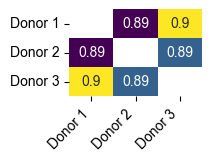

In [102]:

def plot_sample_wise_scores_similarity_donors(scores_store_all_reg1, ax):
    scores_store_table = scores_store_all_reg1.pivot_table(
        index='donor_id', 
        values='r2score', 
        columns=[col for col in scores_store_all_reg1.columns if col not in ['donor_id', 'r2score']]
    ).fillna(0)

    # Calculate the Spearman correlation matrix
    corr_matrix = scores_store_table.T.corr(method='spearman')

    np.fill_diagonal(corr_matrix.values, np.nan)
    # Plot heatmap on the appropriate subplot axis
    sns.heatmap(corr_matrix, annot=True, cmap="viridis", cbar=False, ax=ax)

    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis='y', rotation=0)
    ax.tick_params(axis='x', rotation=45)
    for label in ax.get_xticklabels():
        label.set_ha('right')  # Set horizontal alignment to 'left'



    # plt.title('Performance correlation (OPSCA)', fontsize=12, fontweight='bold', pad=15)
fig, ax = plt.subplots(1, 1, figsize=(2, 1.5), constrained_layout=True)

plot_sample_wise_scores_similarity_donors(scores_store_all_reg1, ax)
# plt.tight_layout()

# fig.savefig(f"{results_folder}/figs/reg1_sample_wise_donor_corr.png", dpi=300, transparent=True, bbox_inches='tight')


### Similarity in performance across models

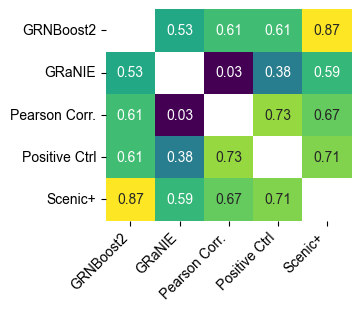

In [103]:
def plot_sample_wise_scores_similarity_models(scores_store_all_reg1, ax):
    scores_store_table = scores_store_all_reg1.pivot_table(
        index='model', 
        values='r2score', 
        columns=[col for col in scores_store_all_reg1.columns if col not in ['model', 'r2score']]
    ).fillna(0)

    spearman_corr = scores_store_table.T.corr(method='spearman')
    np.fill_diagonal(spearman_corr.values, np.nan)
    sns.heatmap(spearman_corr, annot=True, cmap="viridis", cbar=False, ax=ax, fmt='.2f')

    ax.set_xlabel("")
    ax.set_ylabel("")

    ax.tick_params(axis='x', rotation=45)
    for label in ax.get_xticklabels():
        label.set_ha('right')  # Set horizontal alignment to 'left'

    # plt.title('Performance correlation (OPSCA)', fontsize=12, fontweight='bold', pad=15)
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3), constrained_layout=True)

plot_sample_wise_scores_similarity_models(scores_store_all_reg1, ax)
# plt.tight_layout()

fig.savefig(f"{results_folder}/figs/reg1_sample_wise_model_corr.png", dpi=300, transparent=True, bbox_inches='tight')


### Performance segregated by cell types


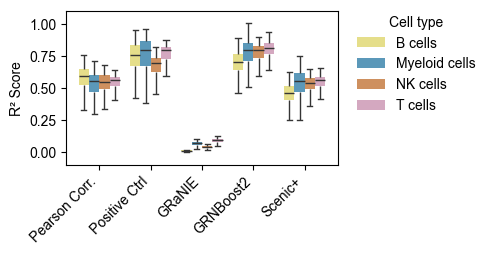

In [104]:

def plot_sample_wise_scores_segregated_by_celltypes(scores_store_all_reg1, ax):

    sns.boxplot(data=scores_store_all_reg1, x="model", y="r2score", hue="cell_type", ax=ax, showfliers=False, palette=colors_blind[3:], boxprops={'edgecolor': 'none', 'alpha':.7} )

    ax.set_ylabel("R² Score")
    ax.set_xlabel("")
    ax.legend(loc=(1.05, .3), title="Cell type", frameon=False)

    # for side in ['right', 'top']:
    #     ax.spines[side].set_visible(False)
    for label in ax.get_xticklabels():
        label.set_ha('right')  # Set horizontal alignment to 'left'
    ax.margins(x=.05, y=.1)
    # plt.title('Performance across cell types (OPSCA)', fontsize=12, fontweight='bold', pad=15)
    ax.tick_params(axis='x', rotation=45)
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
plot_sample_wise_scores_segregated_by_celltypes(scores_store_all_reg1, ax)
# plt.tight_layout()

# fig.savefig(f"{results_folder}/figs/reg1_sample_wise_cell_type.png", dpi=300, transparent=True, bbox_inches='tight')

plt.show()

### Performacne segragated by PC and NC samples

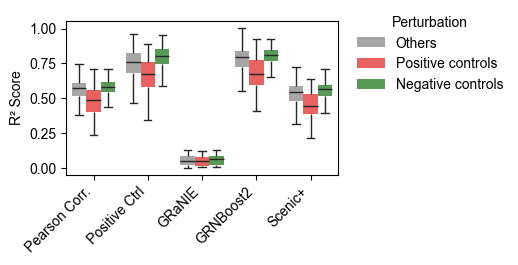

In [105]:
def plot_sample_wise_scores_segregated_by_controls(scores_store_all_reg1, ax):
    scores_store_all_reg1['controls'] = 'Others'
    mask_pc = scores_store_all_reg1.perturbation.isin(['Dabrafenib', 'Belinostat'])
    scores_store_all_reg1.loc[mask_pc, 'controls'] = 'Positive controls'
    mask_nc = scores_store_all_reg1.perturbation.isin(['Dimethyl Sulfoxide'])
    scores_store_all_reg1.loc[mask_nc, 'controls'] = 'Negative controls'

    scores_store_controls = scores_store_all_reg1[scores_store_all_reg1.perturbation.isin(controls3)]

    # - plot for all cell types

    sns.boxplot(data=scores_store_all_reg1, x="model", y="r2score", hue="controls", ax=ax,  palette=['grey']+['red','green'], boxprops={'edgecolor': 'none', 'alpha':.7}, showfliers=False)

    ax.set_ylabel("R² Score")
    ax.set_xlabel("")
    ax.legend(loc=(1.05, .5), title="Perturbation", frameon=False)
    
    # for side in ['right', 'top']:
    #     ax.spines[side].set_visible(False)
    for label in ax.get_xticklabels():
        label.set_ha('right')  # Set horizontal alignment to 'left'

    # plt.title('Performance across compounds (OPSCA)', fontsize=12, fontweight='bold', pad=15)
    ax.tick_params(axis='x', rotation=45)
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

plot_sample_wise_scores_segregated_by_controls(scores_store_all_reg1, ax)
# plt.tight_layout()

# fig.savefig(f"{results_folder}/figs/reg1_sample_wise_compounds.png", dpi=300, transparent=True, bbox_inches='tight')

plt.show()


### Joint distribution of sample wise scores

/Users/jno24/Documents/projs/ongoing/grn_benchmark/notebooks/../../grn_benchmark/src/helper.py:217: UserWarning: 
The palette list has fewer values (7) than needed (8) and will cycle, which may produce an uninterpretable plot.
  sns.kdeplot(data=data, x=x, hue=hue, ax=top_ax, **kde_kws)
/Users/jno24/Documents/projs/ongoing/grn_benchmark/notebooks/../../grn_benchmark/src/helper.py:218: UserWarning: 
The palette list has fewer values (7) than needed (8) and will cycle, which may produce an uninterpretable plot.
  sns.kdeplot(data=data, y=y, hue=hue, ax=side_ax, **kde_kws)
/Users/jno24/Documents/projs/ongoing/grn_benchmark/notebooks/../../grn_benchmark/src/helper.py:217: UserWarning: 
The palette list has fewer values (7) than needed (9) and will cycle, which may produce an uninterpretable plot.
  sns.kdeplot(data=data, x=x, hue=hue, ax=top_ax, **kde_kws)
/Users/jno24/Documents/projs/ongoing/grn_benchmark/notebooks/../../grn_benchmark/src/helper.py:218: UserWarning: 
The palette list has 

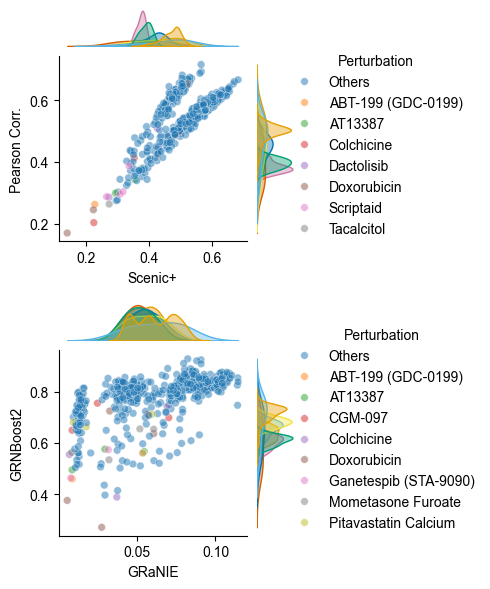

In [106]:
def determine_low_scoring_compounds(scores_store_all_reg1, x_name, y_name):
    if dataset == 'op':
        # Aggregate the data to handle duplicates
        subset_df_agg = scores_store_all_reg1.groupby(['perturbation', 'cell_type', 'model'], as_index=False)['r2score'].mean()
        pivot_df = subset_df_agg.pivot(index=['perturbation', 'cell_type'], columns='model', values='r2score')
    else:
        subset_df_agg = scores_store_all_reg1.groupby([perturb_col, 'model'], as_index=False)['r2score'].mean()
        pivot_df = subset_df_agg.pivot(index=[perturb_col], columns='model', values='r2score')
        pass
    pivot_df = pivot_df.reset_index()
    
    low_score_compounds = pivot_df[[perturb_col, x_name, y_name]].sort_values(by=[x_name, y_name]).head(8)
    low_score_mask = pivot_df[perturb_col].isin(low_score_compounds[perturb_col])
    low_scoring_samples = pivot_df[low_score_mask][perturb_col].unique()
    return low_scoring_samples

def plot_joint_sample_wise_scores(scores_store_all_reg1, x_name, y_name, ax):
    if dataset == 'op':
        # Aggregate the data to handle duplicates
        subset_df_agg = scores_store_all_reg1.groupby(['perturbation', 'cell_type', 'model'], as_index=False)['r2score'].mean()
        pivot_df = subset_df_agg.pivot(index=['perturbation', 'cell_type'], columns='model', values='r2score')
    else:
        subset_df_agg = scores_store_all_reg1.groupby([perturb_col, 'model'], as_index=False)['r2score'].mean()
        pivot_df = subset_df_agg.pivot(index=[perturb_col], columns='model', values='r2score')
        pass
    pivot_df = pivot_df.reset_index()
    
    low_score_compounds = pivot_df[[perturb_col, x_name, y_name]].sort_values(by=[x_name, y_name]).head(8)
    low_score_mask = pivot_df[perturb_col].isin(low_score_compounds[perturb_col])
    low_scoring_samples = pivot_df[low_score_mask][perturb_col].unique()

    pivot_df['perturb_filter'] = 'Others'
    
    pivot_df.loc[low_score_mask, 'perturb_filter'] = pivot_df.loc[low_score_mask, perturb_col]

    # sns.jointplot(
    #     data = pivot_df, 
    #     x = f"{x_name}", 
    #     y = f"{y_name}", 
    #     hue='perturb_filter',   # Color points by "True"/"False"
    #     # style='cell_type',
    #     # markers=True,
    #     # kind="kde",    # Contours with kde
    #     # fill=False,    # Fill contour lines
    #     marginal_kws=dict(common_norm=False, fill=True),  # Marginal distribution,
    #     height=3.5,
    #     alpha=.5
    # )
    custom_jointplot(pivot_df, x = f"{x_name}", 
        y = f"{y_name}", 
        hue='perturb_filter', ax=ax, scatter_kws={'s':30})

    # ax.legend = plt.legend(bbox_to_anchor=(1.7, 1), loc='upper right', borderaxespad=0, frameon=False)

    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    ax.legend(loc=(1.2, 0), title="Perturbation", frameon=False)
    # plt.legend(loc=(1.3, .2))
    return low_scoring_samples
low_scoring_samples_store = []
for i in range(3):
    for j in range(3):
        if i == j:
            continue

        name1 = surragate_names[par_reg1['grn_models'][i]]
        name2 = surragate_names[par_reg1['grn_models'][j]]
        

        low_scoring_samples = determine_low_scoring_compounds(scores_store_all_reg1, name1, name2)

        if (name1.lower()=='granie') | (name2.lower()=='granie'):
            pass
        else:
            low_scoring_samples_store.append(low_scoring_samples)
        # plt.suptitle('Performance across compounds (OPSCA)', fontsize=12, fontweight='bold', y=1.2)

fig, axes = plt.subplots(2, 1, figsize=(5, 6))

ax = axes[0]
plot_joint_sample_wise_scores(scores_store_all_reg1, x_name='Scenic+', y_name='Pearson Corr.', ax=ax)
ax = axes[1]
plot_joint_sample_wise_scores(scores_store_all_reg1, x_name='GRaNIE', y_name='GRNBoost2', ax=ax)

plt.tight_layout()
plt.savefig(f"{results_folder}/figs/reg1_sample_wise_compound.png", dpi=300, transparent=True, bbox_inches='tight')

plt.show()


In [107]:
low_scoring_samples_intersect = np.intersect1d(low_scoring_samples_store[0], low_scoring_samples_store[1])
low_scoring_samples_intersect

array(['ABT-199 (GDC-0199)', 'Colchicine', 'Doxorubicin',
       'Ganetespib (STA-9090)', 'Tacalcitol'], dtype=object)

/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_88372/3636174929.py:15: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  sns.scatterplot(perturb_effect_all, x='STD fold change', y='Expression fold change', hue='perturbation_subset', alpha=.8, ax=ax, palette=sns.color_palette('Set2'))


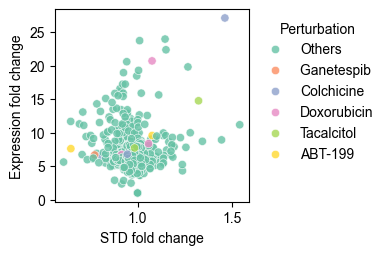

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5))

def plot_perturbation_strength_lowscored_samples(feature_importance_all_reg1, ax):

    low_scoring_samples = np.concatenate(low_scoring_samples_store)
    perturb_effect_all = pd.read_csv(f'{results_folder}/perturb_effect_all.csv')
    perturb_effect_all = perturb_effect_all[perturb_effect_all['Dataset']=='op']
    low_score_mask = perturb_effect_all['perturbation'].isin(low_scoring_samples_intersect)

    perturb_effect_all['perturbation_subset'] = 'Others'
    perturb_effect_all.loc[low_score_mask, 'perturbation_subset'] = perturb_effect_all.loc[low_score_mask, 'perturbation']

    perturb_effect_all['perturbation_subset'] = perturb_effect_all['perturbation_subset'].str.split('(', expand=True)[0]

    sns.scatterplot(perturb_effect_all, x='STD fold change', y='Expression fold change', hue='perturbation_subset', alpha=.8, ax=ax, palette=sns.color_palette('Set2')) 
    # for side in ['right', 'top']:
    #     ax.spines[side].set_visible(False)
    ax.legend(bbox_to_anchor=(1, 1), frameon=False, title="Perturbation")
    # ax.set_title(f"Perturbation strength", pad=10, fontsize=12, fontweight='bold')
plot_perturbation_strength_lowscored_samples(feature_importance_all_reg1, ax)

# fig.savefig(f"{results_folder}/figs/perturbation_strength_lowscored_compounds.png", dpi=300, transparent=True, bbox_inches='tight')

In [109]:
if False:
    fig, ax = plt.subplots(1, 1, figsize=(4,4))
    cmap = sns.color_palette("coolwarm", as_cmap=True)

    scores_store_sub = scores_store[scores_store['model']=='positive_control'][['perturbation','r2score']].rename(columns={'perturbation':'perturbation'})

    perturb_effect_all = perturb_effect_all.merge(scores_store_sub, on='perturbation')

    sns.scatterplot(perturb_effect_all, x='STD fold change', y='Expression fold change', hue='r2score', alpha=.5, ax=ax, palette=cmap)
    legend = ax.legend(bbox_to_anchor=(1.45, 1), loc='upper right', borderaxespad=0, frameon=False)
    legend.set_title("low_score") 

### Feature importance: similarity across models

/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_88372/3449333906.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_pivot = feature_importance_all_reg1.groupby('model').apply(lambda_func)
/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_88372/3449333906.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_pivot = feature_importance_all_reg1.groupby('model').apply(lambda_func)


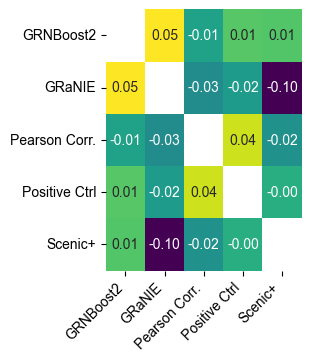

In [110]:

def plot_feature_importance_correlation_variation_across_models(feature_importance_all_reg1, ax):

    # - model specific feature importance -> only intersections 
    def lambda_func(df):
        return df['feature_importance'].values.flatten()

    df_pivot = feature_importance_all_reg1.groupby('model').apply(lambda_func)
    df_pivot = pd.DataFrame(df_pivot.tolist(), index=df_pivot.index)

    spearman_corr = df_pivot.T.corr(method='spearman')

    np.fill_diagonal(spearman_corr.values, np.nan)
    sns.heatmap(spearman_corr, annot=True, cmap="viridis", cbar=False, ax=ax, fmt=".2f")

    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=0)
    for label in ax.get_xticklabels():
        label.set_ha('right')  # Set horizontal alignment to 'left'

    # plt.title('TF activation similarity (OPSCA)', fontsize=12, fontweight='bold', pad=15)
fig, ax = plt.subplots(1, 1, figsize=(3, 3.5), constrained_layout=True)

plot_feature_importance_correlation_variation_across_models(feature_importance_all_reg1, ax)
# plt.tight_layout()

fig.savefig(f"{results_folder}/figs/reg1_feature_importannce_model_corr.png", dpi=300, transparent=True, bbox_inches='tight')

### Feature importance across donors

/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_88372/3294325359.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_pivot = feature_importance_all_reg1.groupby('donor_id').apply(lambda_func)


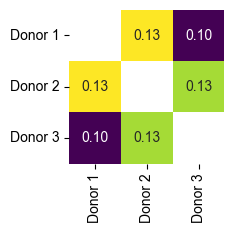

In [111]:
# - feature importance preservation across donors  -> only intersections 

def plot_feature_importance_correlation_variation_across_donors(feature_importance_all_reg1, ax):
    def lambda_func(df):
        return df['feature_importance'].values.flatten()

    # feature_importance
    df_pivot = feature_importance_all_reg1.groupby('donor_id').apply(lambda_func)
    df_pivot = pd.DataFrame(df_pivot.tolist(), index=df_pivot.index)

    # Calculate the Spearman correlation matrix
    corr_matrix = df_pivot.T.corr(method='spearman')

    np.fill_diagonal(corr_matrix.values, np.nan)
    # Plot heatmap on the appropriate subplot axis
    sns.heatmap(corr_matrix, annot=True, cmap="viridis", cbar=False, ax=ax, fmt='.2f')

    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis='y', rotation=0)
    ax.tick_params(axis='x', rotation=90)
    # for label in ax.get_xticklabels():
    #     label.set_ha('right')  # Set horizontal alignment to 'left'


    # plt.title('TF activation similarity (OPSCA)', fontsize=12, fontweight='bold', pad=15)
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
plot_feature_importance_correlation_variation_across_donors(feature_importance_all_reg1, ax)
# plt.tight_layout()

# fig.savefig(f"{results_folder}/figs/reg1_feature_importannce_donor_corr.png", dpi=300, transparent=True, bbox_inches='tight')


In [112]:
if False:
    # Pivot with pivot_table and take the mean of duplicates
    if dataset in ['op']:
        columns = ['model', 'cell_type', perturb_col, 'donor_id']
    else:
        columns = ['model',  perturb_col]

    feature_importance_all_sub = feature_importance_all[feature_importance_all.model.isin(par_reg1['enrichment_models'])]
    feature_importance_common = feature_importance_all_sub.pivot_table(
        index=columns, 
        values='feature_importance', 
        columns='tf',
        aggfunc='mean'  # or 'sum', 'max', etc.
    )
    feature_importance_common = feature_importance_common.loc[:, ~feature_importance_common.isna().any(axis=0)]
    feature_importance_common.head()

    # - get the top features with highest sum across all models
    numeric_df = feature_importance_common.select_dtypes(include='number')
    mean_values_by_tf = numeric_df.groupby(level='tf', axis=1).mean()
    top_n_tfs = mean_values_by_tf.mean().nlargest(10).index
    print("Top 5 TFs with highest average values:")
    print(top_n_tfs)

    tf = 'DRAP1'
    df_one_tf = feature_importance_common[[tf]].reset_index()
    df_one_tf = df_one_tf[df_one_tf.perturbation.isin(controls3)]
    df_one_tf.perturbation = df_one_tf.perturbation.astype(str)

    sns.boxplot(data=df_one_tf, x="model", y=tf, hue="cell_type")
    plt.show()

    g = sns.catplot(
            data=df_one_tf, 
            x='model', 
            y=tf, 
            hue='cell_type', 
            col='perturbation', 
            kind='box',
            height=3, 
            # width=6, 
            aspect=1.4,
            # palette=colors_cell_type,
            legend_out=True
        )
    # Rotate the x-axis labels for all subplots
    for ax in g.axes.flatten():
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.set_xlabel('')
    # Adjust the position of the legend to the right
    g._legend.remove()
    g.add_legend(title="Cell type", bbox_to_anchor=(.95, 0.6), loc='center left')
    prefixes = ['(a)', '(b)', '(c)']
    for i, ax in enumerate(g.axes.flat):
        sub_title = ax.get_title().replace('perturbation = ', f'{prefixes[i]}: ').strip()  # Remove 'Type='
        ax.set_title(sub_title, pad=20)

        ax.margins(x=0.05)

### Feature importance stability across models

In [113]:
df = feature_importance_all_reg1
df_stability_models_reg1 = df.groupby(['perturbation','model'])[['tf', 'feature_importance']].apply(lambda df: df.groupby('tf').apply(lambda row: (np.mean(row)+1E-6)/(np.std(row)+1E-6))).reset_index()
df_stability_models_reg1['contextual_tf_activity'] = 1/df_stability_models_reg1['feature_importance']

/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_88372/1737251834.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_stability_models_reg1 = df.groupby(['perturbation','model'])[['tf', 'feature_importance']].apply(lambda df: df.groupby('tf').apply(lambda row: (np.mean(row)+1E-6)/(np.std(row)+1E-6))).reset_index()
/Users/jno24/miniconda3/envs/py10/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3800: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/jno24/miniconda3/envs/py10/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3800: FutureWarn

In [114]:
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

p_values = {}
for model in df_stability_models_reg1.model.unique():
    baseline = df_stability_models_reg1[df_stability_models_reg1['model']=='GRaNIE']['contextual_tf_activity'].values

    values = df_stability_models_reg1[df_stability_models_reg1['model']==model]['contextual_tf_activity'].values
    stat, p_value = mannwhitneyu(values, baseline, alternative='two-sided')
    # stat, p_value = ttest_ind(values, baseline, alternative='two-sided')
    
    p_values[model] = (1 if (np.median(values)>np.median(baseline)) else -1)*p_value*3

/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_88372/2928796477.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['model'] = filtered_data['model'].astype(category_order_reg1)
/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_88372/2928796477.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(filtered_data, x='model', y='contextual_tf_activity', linewidth=0.5,  cut=0, inner=None, ax=ax, palette=color_map_methods)


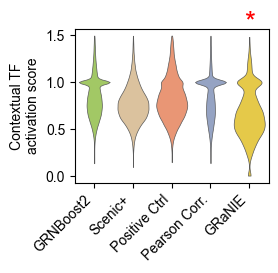

In [156]:

def plot_feature_importance_variation_across_perturbation(feature_importance_all_reg1, ax):

    top_95_quantile = df_stability_models_reg1['contextual_tf_activity'].quantile(0.99)
    filtered_data = df_stability_models_reg1[df_stability_models_reg1['contextual_tf_activity'] <= top_95_quantile]
    filtered_data['model'] = filtered_data['model'].astype(category_order_reg1)
    # sns.boxplot(df_stability_models_reg1, x='model', y='contextual_tf_activity', showfliers=False, boxprops={'edgecolor': 'none'}, ax=ax, palette=colors_methods_reg1)
    sns.violinplot(filtered_data, x='model', y='contextual_tf_activity', linewidth=0.5,  cut=0, inner=None, ax=ax, palette=color_map_methods)

    
    ax.set_ylabel('Contextual TF\nactivation score')

    ax.set_xlabel("")
    # ax.legend(loc=(1, .5), title="Perturbation", frameon=False)

    # for side in ['right', 'top']:
    #     ax.spines[side].set_visible(False)

    # plt.title('TF activation stability across perturbation (OPSCA)', fontsize=12, fontweight='bold', pad=15)
    ax.tick_params(axis='x', rotation=45)
    for label in ax.get_xticklabels():
        label.set_ha('right')  # Set horizontal alignment to 'left'
    sigs = ['','','','','*']
    positions = [filtered_data['contextual_tf_activity'].max()]*5
    i = 0
    for ii, row_name in enumerate(range(df_stability_models_reg1['model'].nunique())):
        ax.text(
            i,  # x-coordinate
            positions[ii],  # Position above the highest point in the box
            sigs[ii],  # Format p-value in scientific notation
            ha='center',
            va='bottom',
            fontsize=20,
            color='red'
        )
        i+=1

    # plt.tight_layout()
fig, ax = plt.subplots(1, 1, figsize=(2.5, 2))

plot_feature_importance_variation_across_perturbation(feature_importance_all_reg1, ax)
fig.savefig(f"{results_folder}/figs/reg1_tf_activation_stability.png", dpi=300, transparent=True, bbox_inches='tight')


plt.show()

In [116]:

if False:
    def plot_feature_importance_variation_across_perturbation(feature_importance_all_reg1, ax):

        df = feature_importance_all_reg1[feature_importance_all_reg1['perturbation'].isin(controls3)]
        df = df.groupby(['perturbation','model'])[['tf', 'feature_importance']].apply(lambda df: df.groupby('tf').apply(lambda row: (np.mean(row)+1E-6)/(np.std(row)+1E-6))).reset_index()

        sns.boxplot(df, x='model', y='contextual_tf_activity', hue='perturbation', showfliers=False, palette=colors_blind, boxprops={'edgecolor': 'none'}, ax=ax)
        ax.set_ylabel('Contextual TF activity')

        ax.set_xlabel("")
        ax.legend(loc=(1, .5), title="Perturbation", frameon=False)

        for side in ['right', 'top']:
            ax.spines[side].set_visible(False)

        # plt.title('TF activation stability across perturbation (OPSCA)', fontsize=12, fontweight='bold', pad=15)
        ax.tick_params(axis='x', rotation=45)

        # plt.tight_layout()
    fig, ax = plt.subplots(1, 1, figsize=(4, 3))

    plot_feature_importance_variation_across_perturbation(feature_importance_all_reg1, ax)
    # fig.savefig(f"{results_folder}/figs/reg1_feature_importance_stability.png", dpi=300, transparent=True, bbox_inches='tight')

    plt.show()

# Stability analysis: Regression 2

In [117]:
dataset = 'op' #'nakatake' #op', norman


par_reg2 = {
    'grn_models': ['positive_control', 'pearson_corr', 'grnboost2', 'ppcor'],
    'best_performers': ['pearson_corr', 'positive_control', 'grnboost2'],
    'worse_performers': ['ppcor'],
    'grn_models_dir': f'{task_grn_inference_dir}/resources/grn_models/{dataset}/',
    'evaluation_data': f'{task_grn_inference_dir}/resources/evaluation_data/{dataset}_perturbation.h5ad',
    'layer': 'X_norm',
    'consensus':  f'../output/{dataset}_consensus-num-regulators.json',
    'tf_all': f'{task_grn_inference_dir}/resources/prior/tf_all.csv',
    'static_only': False,
    'num_workers': 4,
    'apply_tf': True,
    'apply_skeleton': False,
    'verbose': 2,
    'max_n_links': 50_000
}

exp_objs_dict = {}

for model in par_reg2['grn_models']:
    par_reg2['grn_model'] = f"{par_reg2['grn_models_dir']}/{model}.csv"
    if not os.path.exists(par_reg2['grn_model']):
        print(model, ' is skipped')
        continue
    net = pd.read_csv(par_reg2['grn_model'])

    print(model, len(net))
    obj = Exp_analysis(net)
    obj.calculate_basic_stats()
    exp_objs_dict[model] = obj


interaction_info = create_interaction_info(exp_objs_dict)
# fig = plot_interactions(interaction_info['target'], min_subset_size = 1, min_degree=1, color_map=None) 

positive_control 50000
pearson_corr 50000
grnboost2 50000
ppcor 50000


### Run the metric

In [118]:
# - imports 
sys.path.append('../../task_grn_inference/src/utils')

# - read inputs
tf_all = np.loadtxt(f'{task_grn_inference_dir}/resources/prior/tf_all.csv', dtype=str)

perturb_data = ad.read_h5ad(par_reg2['evaluation_data'])
gene_names = perturb_data.var_names
perturb_data

AnnData object with n_obs × n_vars = 2170 × 15215
    obs: 'cell_type', 'well', 'donor_id', 'row', 'perturbation', 'plate_name', 'cell_count', 'is_control', 'is_positive_control'
    layers: 'X_norm', 'counts', 'lognorm'

In [119]:
# - calculate the scores and feature importance 
if False:
    # from task_grn_inference.src.metrics.regression_2.main import *
    #- create consensuns
    from task_grn_inference.src.metrics.consensus.script import main
    par_reg2['models'] = par_reg2['grn_models']
    par_reg2['models_dir'] = par_reg2['grn_models_dir']
    main(par)

    if 'donor_id' not in perturb_data.obs:
        perturb_data.obs['donor_id'] = 'donor_one'
        perturb_data.obs['cell_type'] = 'cell_type'


    # - run reg
    scores_store = []

    i_iter = 0
    for reg_type in ['ridge']:
        for donor_id in perturb_data.obs.donor_id.unique():
            perturb_data_sub = perturb_data[perturb_data.obs.donor_id == donor_id]
            # perturb_data_sub = perturb_data_sub[:5, :] #TODO: remove this
            obs = perturb_data_sub.obs.reset_index(drop=True)

            for i_model, model in enumerate(par_reg2['grn_models']):
                net = pd.read_csv(f"{par_reg2['grn_models_dir']}/{model}.csv")
                
                net_matrix = net_to_matrix(net, gene_names, par)

                n_cells = perturb_data_sub.shape[0]
                random_groups = np.random.choice(range(1, 5+1), size=n_cells, replace=True) # random sampling
                groups = LabelEncoder().fit_transform(random_groups)

                # Load and standardize perturbation data
                layer = par_reg2['layer']
                if  layer=='X':
                    X = perturb_data_sub.X
                else:
                    X = perturb_data_sub.layers[layer]
                
                try:
                    X = X.todense().A
                except:
                    pass

                X = RobustScaler().fit_transform(X)

                # Load consensus numbers of putative regulators
                with open(par_reg2['consensus'], 'r') as f:
                    data = json.load(f)
                gene_names_ = np.asarray(list(data.keys()), dtype=object)
                n_features_dict = {gene_name: i for i, gene_name in enumerate(gene_names_)}

                n_features_theta_median = np.asarray([data[gene_name]['0.5'] for gene_name in gene_names], dtype=int)

                # Load list of putative TFs
                tf_names = np.loadtxt(par_reg2['tf_all'], dtype=str)
                if par_reg2['apply_tf']==False:
                    tf_names = gene_names

                rr_all = cross_validate(reg_type, gene_names, tf_names, X, groups, net_matrix, n_features_theta_median, n_jobs=par_reg2['num_workers'])

                r2_scores = np.asarray([rr_all['results'][j]['avg-r2'] for j in range(len(rr_all['results']))])
                mean_r2_scores = np.mean(r2_scores)

                print(mean_r2_scores)
                
                for i_gene, gene in enumerate(rr_all['gene_names']):
                    present = gene in net.target.unique()
                    r2score = rr_all['results'][i_gene]['avg-r2']
                    
                    reg_models = rr_all['results'][i_gene]['models']

                    # if False: # skip feature importance for now
                    if reg_type == 'ridge':
                        coeffs = [reg.coef_ for reg in reg_models]
                    else:
                        coeffs = [reg.get_feature_importance() for reg in reg_models]
                    coeffs = np.asarray(coeffs)
                    n_regulator = coeffs.shape[1]
                    


                    scores_store.append({
                        'reg_type': reg_type,
                        'donor_id':donor_id,
                        'r2score': r2score,
                        'present':present,
                        'model': model,
                        'gene': gene,
                        'n_regulator': n_regulator,
                        'n_present_regulators': net[net.target==gene]['source'].nunique(),
                        'feature_importance_mean2std': np.mean(np.abs(np.mean(coeffs, axis=0)+1E-6)/(np.std(coeffs, axis=0)+1E-6)).round(3)
                    })
                i_iter+=1
                
    scores_store = pd.DataFrame(scores_store)
    scores_store.to_csv(f'{results_folder}/{dataset}_reg2_scores_store.csv')
    # feature_importance_all.to_csv(f'{results_folder}/reg2_feature_importance.csv')

In [120]:
# - retreive regresion results
scores_store_all_reg2= pd.read_csv(f'{results_folder}/{dataset}_reg2_scores_store.csv', index_col=0)
scores_store_all_reg2['feature_importance_mean2std_log'] = np.log1p(scores_store_all_reg2['feature_importance_mean2std'])
scores_store_all_reg2['contextual_tf_activity'] = 1/scores_store_all_reg2['feature_importance_mean2std']
scores_store_all_reg2

,reg_type,donor_id,r2score,present,model,gene,n_regulator,n_present_regulators,feature_importance_mean2std,feature_importance_mean2std_log,contextual_tf_activity
0,ridge,donor_0,0.466437,False,positive_control,A2M,8,0,14.752,2.756967,0.067787
1,ridge,donor_0,0.783141,False,positive_control,A2M-AS1,6,0,13.370,2.665143,0.074794
2,ridge,donor_0,0.034241,False,positive_control,AAK1,2,0,5.768,1.912206,0.173370
3,ridge,donor_0,0.034882,False,positive_control,AAMP,1,0,13.156,2.650139,0.076011
4,ridge,donor_0,0.269385,False,positive_control,AARS,2,0,15.974,2.831683,0.062602
...,...,...,...,...,...,...,...,...,...,...,...
64711,ridge,donor_2,0.082894,False,ppcor,ZSCAN18,1,0,17.919,2.940167,0.055807
64712,ridge,donor_2,0.743848,True,ppcor,ZSWIM6,8,5,15.870,2.825537,0.063012
64713,ridge,donor_2,0.000000,True,ppcor,ZXDC,1,2,1.250,0.810930,0.800000
64714,ridge,donor_2,0.375270,True,ppcor,ZYX,6,1,19.364,3.013769,0.051642


In [121]:
scores_store_all_reg2.model = scores_store_all_reg2.model.map(surragate_names)

scores_store_all_reg2['donor_id'] = scores_store_all_reg2['donor_id'].map({'donor_0':'Donor 1', 'donor_1':'Donor 2', 'donor_2':'Donor 3'})

scores_store_present = scores_store_all_reg2[scores_store_all_reg2['present']]


### Feature stability scores

In [150]:
def plot_reg2_feature_stability_scores(scores_store_all_reg2, ax):
    from scipy.stats import mannwhitneyu

    scores_store_present = scores_store_all_reg2[scores_store_all_reg2['present']]
    df_common_pivot = scores_store_present.pivot(index=['model'], columns=['donor_id','gene'], values='feature_importance_mean2std').dropna(axis=1)
    common_genes = df_common_pivot.columns.get_level_values('gene').unique()

    df = df_common_pivot


    # Reference row
    ref = df_common_pivot.loc['Positive Ctrl']



    # - stability changes 
    import seaborn as sns

    top_95_quantile = scores_store_present['contextual_tf_activity'].quantile(0.99)
    filtered_data = scores_store_present[scores_store_present['contextual_tf_activity'] <= top_95_quantile]

    filtered_data['model'] = filtered_data['model'].astype(category_order_reg2)
    # sns.boxplot(data=scores_store_present, x='model', y='contextual_tf_activity', ax=ax, palette=colors_blind, showfliers=False)
    sns.violinplot(filtered_data, x='model', y='contextual_tf_activity', linewidth=0.5,  cut=-1, inner=None, ax=ax, palette=color_map_methods)

    ax.set_xlabel("")
    ax.set_ylabel("Contextual TF\nactivity score")


    # for side in ['right', 'top']:
    #     ax.spines[side].set_visible(False)
    # ax.set_yscale('log')
    # plt.suptitle('TF activation, regression 2', fontsize=12, fontweight='bold', y=1.01)
    ax.tick_params(axis='x', rotation=45)
    for label in ax.get_xticklabels():
        label.set_ha('right')  # Set horizontal alignment to 'left'

    sigs = ['','','','*','']
    positions = [.75]*4
    i = 0
    for ii, row_name in enumerate(range(scores_store_present['model'].nunique())):
        ax.text(
            i,  # x-coordinate
            positions[ii],  # Position above the highest point in the box
            sigs[ii],  # Format p-value in scientific notation
            ha='center',
            va='bottom',
            fontsize=20,
            color='red'
        )
        i+=1

# fig, ax = plt.subplots(1, 1, figsize=(2.5, 2))
# plot_reg2_feature_stability_scores(scores_store_all_reg2, ax)
# # plt.tight_layout()

# fig.savefig(f"{results_folder}/figs/reg2_feature_importance_stability.png", dpi=300, transparent=True, bbox_inches='tight')

# plt.show()


### Number of regulators vs r2 scores and tf activation stability

In [151]:
def plot_tf_activation_grn_derived(ax):
    top_95_quantile = scores_store_all_reg2['contextual_tf_activity'].quantile(.98)
    filtered_data = scores_store_all_reg2[scores_store_all_reg2['contextual_tf_activity'] <= top_95_quantile]
    sns.violinplot(filtered_data, x='present', y='contextual_tf_activity', linewidth=0.5,  cut=0, inner=None, ax=ax, palette=colors_blind)

    ax.set_ylabel('Contextual TF\nactivation score')

    ax.set_xlabel("")
    ax.set_xticklabels(['Random','GRN derived'])

    # plt.title('TF activation stability across perturbation (OPSCA)', fontsize=12, fontweight='bold', pad=15)
    ax.tick_params(axis='x', rotation=0)

    sigs = ['*','','','','']
    positions = [.75]*5
    i = 0
    for ii, row_name in enumerate(range(df_stability_models_reg1['model'].nunique())):
        ax.text(
            i,  # x-coordinate
            positions[ii],  # Position above the highest point in the box
            sigs[ii],  # Format p-value in scientific notation
            ha='center',
            va='bottom',
            fontsize=20,
            color='red'
        )
        i+=1
# fig, ax = plt.subplots(1, 1, figsize=(2, 2), sharex=True)
# plot_tf_activation_grn_derived(ax)
# plt.savefig(f"{results_folder}/figs/reg2_grnderived_stability.png", dpi=300, transparent=True, bbox_inches='tight')


/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_88372/4158060896.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['model'] = filtered_data['model'].astype(category_order_reg2)
/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_88372/4158060896.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(filtered_data, x='model', y='contextual_tf_activity', linewidth=0.5,  cut=-1, inner=None, ax=ax, palette=color_map_methods)
/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_88372/3905386170.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is 

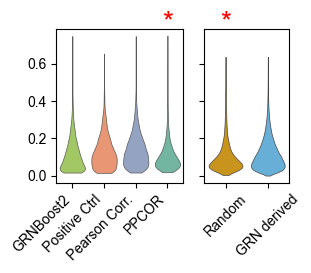

In [158]:
fig, axes = plt.subplots(1, 2, figsize=(3, 2), width_ratios=[1.5, 1], sharey=True)
ax = axes[0]
plot_reg2_feature_stability_scores(scores_store_all_reg2, ax)
ax.set_ylabel('')
ax = axes[1]
plot_tf_activation_grn_derived(ax)
ax.tick_params(axis='x', rotation=45)
# plt.suptitle('R2', y=1.1)
ax.set_ylabel('')
plt.savefig(f"{results_folder}/figs/reg2_tf_activation.png", dpi=300, transparent=True, bbox_inches='tight')


/Users/jno24/Documents/projs/ongoing/grn_benchmark/notebooks/../../grn_benchmark/src/helper.py:213: UserWarning: The palette list has more values (7) than needed (2), which may not be intended.
  sns.scatterplot(data=data, x=x, y=y, hue=hue, ax=ax, alpha=alpha, **scatter_kws)
/Users/jno24/Documents/projs/ongoing/grn_benchmark/notebooks/../../grn_benchmark/src/helper.py:218: UserWarning: The palette list has more values (7) than needed (2), which may not be intended.
  sns.kdeplot(data=data, y=y, hue=hue, ax=side_ax, **kde_kws)


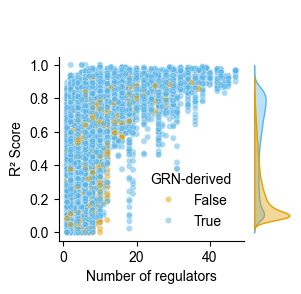

In [125]:
def plot_joint_reg2_tf_activation_vs_nregulators(scores_store_all_reg2, ax, top_plot=True):
    # scores_store_all_reg2
    custom_jointplot(scores_store_all_reg2,x = 'n_regulator', 
             y = 'contextual_tf_activity', 
             hue= 'present', ax=ax, scatter_kws={'s':20})
    ax.legend(title="GRN-derived", frameon=False)
    ax.set_xlabel("Number of regulators")
    ax.set_ylabel("contextual_tf_activation")
def plot_joint_reg2_r2scores_vs_nregulators(scores_store_all_reg2, ax, top_plot=True):
    custom_jointplot(scores_store_all_reg2,x = 'n_regulator', 
             y = 'r2score', 
             hue= 'present', ax=ax, scatter_kws={'s':20, 'palette':colors_blind}, top_plot=top_plot)
    ax.legend(title="GRN-derived", frameon=False)
    ax.set_xlabel("Number of regulators")
    ax.set_ylabel("R² Score")
fig, ax = plt.subplots(1, 1, figsize=(3, 3), sharex=True)
# ax = axes[0]
plot_joint_reg2_r2scores_vs_nregulators(scores_store_all_reg2, ax,  top_plot=False)
# ax.get_legend().remove()

# ax = axes[1]
# plot_joint_reg2_tf_activation_vs_nregulators(scores_store_all_reg2, ax, top_plot=False)

# plt.subplots_adjust(
#     left=0.1,  # Space from the left edge of the figure
#     right=0.95,  # Space from the right edge of the figure
#     top=0.9,  # Space from the top of the figure
#     bottom=0.12,  # Space from the bottom of the figure
#     hspace=0.1,  # Height (vertical) space between rows
#     wspace=.3   # Width (horizontal) space between columns
# )

plt.savefig(f"{results_folder}/figs/reg2_nregulators_vs_r2scoes.png", dpi=300, transparent=True, bbox_inches='tight')

plt.show()

### Similary of scores across donors

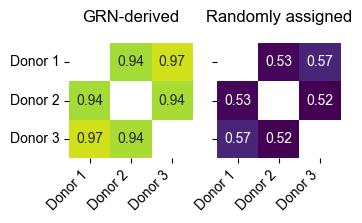

In [126]:
# Function to plot a heatmap with consistent color scaling

def plot_reg2_perfromance_similarity_donors(scores_store_all_reg2, axes):
    def plot_this_one(corr_matrix, ax, vmin, vmax):
        np.fill_diagonal(corr_matrix.values, np.nan)  # Optional: mask diagonal
        sns.heatmap(
            corr_matrix, 
            annot=True, 
            cmap="viridis", 
            cbar=False, 
            ax=ax, 
            vmin=vmin, 
            vmax=vmax
        )
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.tick_params('y', rotation=0)
    # Calculate correlation matrices for both conditions
    # GRN derived
    scores_store_table = scores_store_all_reg2[scores_store_all_reg2['present']][['donor_id', 'r2score', 'model', 'gene']].pivot(
        index='donor_id', 
        values='r2score', 
        columns=['model', 'gene']
    )
    corr_matrix_grn = scores_store_table.T.corr(method='spearman')

    # Randomly assigned
    scores_store_table = scores_store_all_reg2[~scores_store_all_reg2['present']][['donor_id', 'r2score', 'model', 'gene']].pivot(
        index='donor_id', 
        values='r2score', 
        columns=['model', 'gene']
    )
    corr_matrix_random = scores_store_table.T.corr(method='spearman')

    # Determine the global vmin and vmax for consistent color scale
    vmin = min(corr_matrix_grn.min().min(), corr_matrix_random.min().min())
    vmax = max(corr_matrix_grn.max().max(), corr_matrix_random.max().max())

    # Plot the heatmaps
    plot_this_one(corr_matrix_grn, axes[0], vmin, vmax)
    axes[0].set_title('GRN-derived', pad=15)
    axes[0].tick_params(axis='x', rotation=45)
    for label in axes[0].get_xticklabels():
        label.set_ha('right')  # Set horizontal alignment to 'left'


    plot_this_one(corr_matrix_random, axes[1], vmin, vmax)
    axes[1].set_title('Randomly assigned', pad=15)

    axes[1].tick_params(axis='x', rotation=45)
    for label in axes[1].get_xticklabels():
        label.set_ha('right')  # Set horizontal alignment to 'left'



    # Set global title and save figure
fig, axes = plt.subplots(1, 2, figsize=(3.5, 1.5), sharey=True)

plot_reg2_perfromance_similarity_donors(scores_store_all_reg2, axes)
# plt.suptitle('Performance correlation, regression 2', fontsize=12, fontweight='bold', y=1.01)
# plt.tight_layout()
# fig.savefig(
#     f"{results_folder}/figs/reg2_scores_similarity_donors.png", 
#     dpi=300, 
#     transparent=True, 
#     bbox_inches='tight'
# )

### Similariy of scores across models

/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_88372/2678502144.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


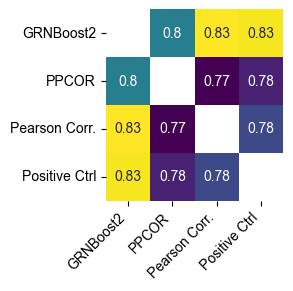

In [127]:
def plot_reg2_perfromance_similarity_models(scores_store_all_reg2, ax):


    scores_store_table = scores_store_all_reg2[['donor_id', 'r2score', 'model', 'gene']].pivot(
                index='model', 
                values='r2score', 
                columns=['donor_id', 'gene']
            )

    spearman_corr = scores_store_table.T.corr(method='spearman')
    np.fill_diagonal(spearman_corr.values, np.nan)
    sns.heatmap(spearman_corr, annot=True, cmap="viridis", cbar=False, ax=ax)

    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params('y', rotation=0)

    ax.tick_params(axis='x', rotation=45)
    for label in ax.get_xticklabels():
        label.set_ha('right')  # Set horizontal alignment to 'left'

    # plt.title('Performance correlation (OPSCA)', fontsize=12, fontweight='bold', pad=15)
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5), constrained_layout=True)

plot_reg2_perfromance_similarity_models(scores_store_all_reg2, ax)
plt.tight_layout()

fig.savefig(f"{results_folder}/figs/reg2_models_corr.png", dpi=300, transparent=True, bbox_inches='tight')


### Joint distribution of gene wise scores

In [128]:
# scores_store_all_reg2

In [129]:
# scores_store_all_reg2['model'].unique()

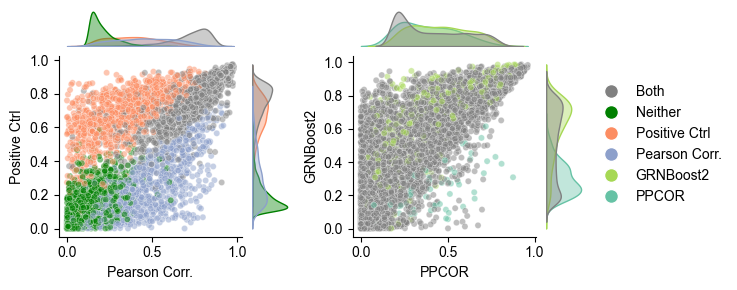

In [145]:
sys.path.append('../')
from src.helper import custom_jointplot
def plot_joint_gene_scores(method1, method2, ax):
    

    
    scores_store_table = scores_store_all_reg2.pivot_table(index='gene', columns='model', values='r2score', aggfunc='mean')

    # - add common gene specs 
    present_table = scores_store_all_reg2.pivot_table(index='gene', columns='model', values='present', aggfunc='mean')
    present_table = present_table.astype(bool)

    scores_store_table['present'] = 'Neither'
    scores_store_table.loc[present_table[method1], 'present'] = method1
    scores_store_table.loc[present_table[method2], 'present'] = method2
    scores_store_table.loc[present_table[method1]&present_table[method2], 'present'] = 'Both'

    # for name in ['None', method1, method2, 'Both']:
    #     mask = scores_store_table['present'] == name
    #     n = (mask).sum()
    #     scores_store_table.loc[mask, 'present'] += f' ({n})'

    custom_jointplot(scores_store_table,x = method1, 
             y = method2, 
             hue= 'present', ax=ax,
             scatter_kws={'s':20, 
             'palette':[color_map[name] for name in scores_store_table['present'].unique()]},
            #  'palette':[color_map[name] for name in ['Positive Ctrl', 'Pearson Corr.', 'GRNBoost2', 'PPCOR', 'None', 'Both']]},
              alpha=.5)

    ax.legend(loc=(1.18, .35), title="Present", frameon=False)
    return scores_store_table

color_map = {'Neither':'green', 'Both':'grey', **color_map_methods}

figsize = (7.5, 3)
fig, axes = plt.subplots(1, 2, figsize=figsize)

ax = axes[0]
aa = plot_joint_gene_scores('Pearson Corr.', 'Positive Ctrl', ax=ax)
ax.get_legend().remove()
ax = axes[1]
aa = plot_joint_gene_scores('PPCOR', 'GRNBoost2', ax=ax)
ax.get_legend().remove()

# Create legend handles
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[name], markersize=10, label=name)
    for name in ['Both', 'Neither', 'Positive Ctrl', 'Pearson Corr.', 'GRNBoost2', 'PPCOR']
]

ax.legend(handles=legend_elements, title="", loc=(1.3, .15), frameon=False)



plt.tight_layout()
plt.savefig(f"{results_folder}/figs/reg2_joint_r2scores.png", dpi=300, transparent=True, bbox_inches='tight')

        

# Topological analysis

In [2]:
order_names =[surragate_names[name] for name in ['pearson_corr', 'grnboost2', 'portia', 'ppcor']]


In [3]:
exp_objs_dict_dict = {}
for dataset in datasets:
# dataset = 'op' #'op', nakatake, adamson
    par_top_analysis = {
        
            'grn_models': ['positive_control', 'pearson_corr', 'ppcor', 'portia', 'grnboost2', 'scenic', 'scglue', 'celloracle', 'figr', 'granie', 'scenicplus'],
            # 'grn_models': [ 'positive_control', 'pearson_corr', 'grnboost2', 'scenicplus', 'celloracle'],
            'shortlist': ['pearson_corr', 'ppcor', 'portia', 'grnboost2'],

            'peak_gene_models': ['celloracle', 'scenicplus', 'figr', 'granie'],
            'grn_models_dir': f'{task_grn_inference_dir}/resources/grn_models/{dataset}/',
            'peak_gene_dir': f'{task_grn_inference_dir}/resources/grn_models/{dataset}/peak_gene/',
    }

    exp_objs_dict = {}
    nets_dict = {}

    for model in par_top_analysis['grn_models']:
        par_top_analysis['grn_model'] = f"{par_top_analysis['grn_models_dir']}/{model}.csv"
        if not os.path.exists(par_top_analysis['grn_model']):
            print(model, ' is skipped')
            continue
        net = pd.read_csv(par_top_analysis['grn_model'])

        net = net.drop_duplicates()
        
        nets_dict[model] = net

        if model in par_top_analysis['peak_gene_models']:
            peak_gene_net = pd.read_csv(f"{par_top_analysis['peak_gene_dir']}/{model}.csv")
        else:
            peak_gene_net = None
        print(model, len(net))
        obj = Exp_analysis(net, peak_gene_net)
        obj.calculate_basic_stats()
        obj.calculate_centrality()

        exp_objs_dict[model] = obj
    exp_objs_dict = {surragate_names[key]:value for key,value in exp_objs_dict.items()}
    exp_objs_dict_dict[dataset] = exp_objs_dict

positive_control 50000
pearson_corr 50000
ppcor 50000
portia 50000
grnboost2 50000
scenic 64489
scglue 7227
celloracle 50000
figr 52962
granie 50000
scenicplus 41288
positive_control 50000
pearson_corr 50000
ppcor 50000
portia 50000
grnboost2 50000
scenic 18031
scglue  is skipped
celloracle  is skipped
figr  is skipped
granie  is skipped
scenicplus  is skipped
positive_control 50000
pearson_corr 50000
ppcor 50000
portia 50000
grnboost2 50000
scenic 99500
scglue  is skipped
celloracle  is skipped
figr  is skipped
granie  is skipped
scenicplus  is skipped
positive_control 50000
pearson_corr 50000
ppcor 50000
portia 50000
grnboost2 50000
scenic 2182
scglue  is skipped
celloracle  is skipped
figr  is skipped
granie  is skipped
scenicplus  is skipped
positive_control 50000
pearson_corr 50000
ppcor 50000
portia 50000
grnboost2 50000
scenic  is skipped
scglue  is skipped
celloracle  is skipped
figr  is skipped
granie  is skipped
scenicplus  is skipped


## General stats

In [4]:
for i, dataset in enumerate(datasets):
    exp_objs_dict = exp_objs_dict_dict[dataset]
    # regulatory links
    links_n = {}
    source_n = {}
    target_n = {}
    nets = {}

    for name, obj in exp_objs_dict.items():
        net = obj.net
        if 'cell_type' in net.columns: # for cell specific grn models, take the mean
            n_grn = net.groupby('cell_type').size().mean()
        else:
            n_grn = len(net)

        links_n[name] = n_grn
        source_n[name] = obj.stats['n_source']
        target_n[name] = obj.stats['n_target']
    # Prepare data for plotting
    data = {
        'Model': [],
        'Count': [],
        'Type': []
    }

    # Populate the data dictionary for each metric
    for model in links_n.keys():
        data['Model'].append(model)
        data['Count'].append(links_n[model])
        data['Type'].append('Putative links')

    for model in source_n.keys():
        data['Model'].append(model)
        data['Count'].append(source_n[model])
        data['Type'].append('Putative TFs')

    for model in target_n.keys():
        data['Model'].append(model)
        data['Count'].append(target_n[model])
        data['Type'].append('Putative target genes')

    # Create a DataFrame from the data dictionary
    df = pd.DataFrame(data)
    df['Dataset'] = dataset
    if i == 0:
        topology_stats =df
    else:
        topology_stats = pd.concat([topology_stats, df]).reset_index(drop=True)
topology_stats.loc[topology_stats['Count']>50000, 'Count'] = 50000
topology_stats['Dataset'] = topology_stats['Dataset'].map(surragate_names)


In [5]:
n_target_genes_datasets = {surragate_names[name]:value for name, value in  n_target_genes_datasets.items()}

NameError: name 'n_target_genes_datasets' is not defined

In [135]:
# - normalize the counts
topology_stats['n_count'] = 0
for type in topology_stats['Type'].unique():
    mask = topology_stats['Type'] == type
    if type == 'Putative links':

        topology_stats.loc[mask, 'n_count'] = (topology_stats['Count']/50000).clip(upper=1)
        
    elif type == 'Putative TFs':
        max_n = 1000 
        topology_stats.loc[mask, 'n_count'] = topology_stats.loc[mask, 'Count']/max_n
    elif type == 'Putative target genes':
        for dataset in topology_stats['Dataset'].unique():
            mask_dataset = topology_stats['Dataset'] == dataset
            max_n = n_target_genes_datasets[dataset]
            topology_stats.loc[mask&mask_dataset, 'n_count'] = topology_stats.loc[mask&mask_dataset, 'Count']/max_n
        
    else:
        raise ValueError(type)


/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_88372/456910255.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.      1.      1.      1.      1.      1.      0.14454 1.      1.
 1.      0.82576 1.      1.      1.      1.      1.      0.36062 1.
 1.      1.      1.      1.      1.      1.      1.      1.      1.
 1.      0.04364 1.      1.      1.      1.      1.     ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  topology_stats.loc[mask, 'n_count'] = (topology_stats['Count']/50000).clip(upper=1)


dict_keys(['op', 'nakatake'])


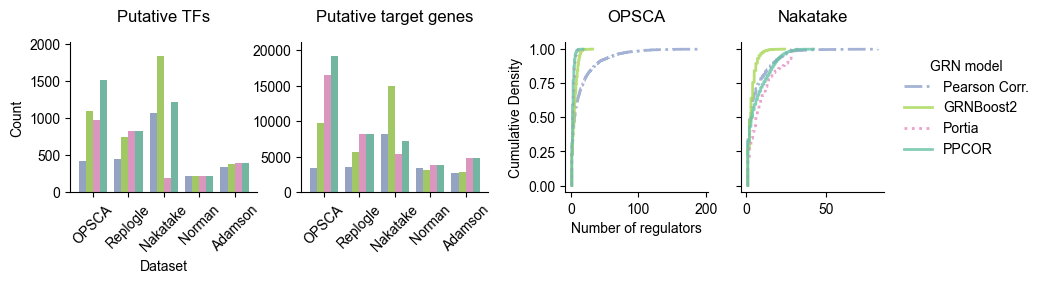

In [136]:
def plot_topology_short(axes):
    topology_stats_short = topology_stats[topology_stats['Model'].isin(order_names)]
    topology_stats_short = topology_stats_short[topology_stats_short['Type'].isin(['Putative TFs', 'Putative target genes'])]
    
    for i, type in enumerate(topology_stats_short['Type'].unique()):
        ax = axes[i]
        topology_stats_sub = topology_stats_short[topology_stats_short['Type']==type]
        sns.barplot(
            ax=ax,
            data=topology_stats_sub,
            hue='Model',
            hue_order=order_names,  # Specify the desired order of hue categories
            x='Dataset',
            y='Count',
            alpha=1,
            palette=color_map_methods,
            # sharey=False,
            # height=2.2,  # Adjust plot size (smaller)
            # aspect=1.2    # Adjust aspect ratio
        )
        ax.get_legend().remove()
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.margins(x=.05, y=.1)
        
        ax.tick_params(axis='x', rotation=45)
        ax.set_title(type, pad=15)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        if i == 1:
            ax.set_xlabel('')
            ax.set_ylabel('')
        else:
            ax.set_xlabel('Dataset')

def plot_indegree_centrality(exp_objs_dict_dict, axes):
    print(exp_objs_dict_dict.keys())
    for i, dataset in enumerate(exp_objs_dict_dict.keys()):
        exp_objs_dict = exp_objs_dict_dict[dataset]
        ax = axes[i]
        for name in ['Pearson Corr.', 'GRNBoost2', 'Portia', 'PPCOR']:
            name = surragate_names.get(name,name)
            obj = exp_objs_dict[name]
            obj.calculate_centrality()
            values = obj.tf_gene.in_deg.degree.values

            obj.plot_cumulative_density(values, title='', x_label='Number of regulators', ax=ax, alpha=.8, label=name, c=color_map_methods[name], linestyle=linestyle_map_methods[name], linewidth=2)
            
            # ax.set_xlim([-5, 250])
            # ax.set_title('(a) In-degree centrality: TF-gene', pad=20)
        # plt.tight_layout()
        if i != 0:
            ax.set_ylabel('')
            ax.set_xlabel('')
        ax.set_title(surragate_names[dataset], pad=15)
        ax.grid(False)
    ax.legend(frameon=False, loc=(1.1, .5))

fig = plt.figure(figsize=(11, 2))
gs = fig.add_gridspec(1, 5)
ax1 = fig.add_subplot(gs[0, 0]) 
ax2 = fig.add_subplot(gs[0, 1]) 
ax3 = fig.add_subplot(gs[0, 2]) 
ax4 = fig.add_subplot(gs[0, 3]) 
plot_topology_short([ax1, ax2])
plot_indegree_centrality({key:value for key, value in exp_objs_dict_dict.items() if key in ['op', 'nakatake']}, [ax3, ax4])
ax4.set_yticklabels([])
ax4.legend(frameon=False, loc=(1.1, .2), title='GRN model')

ax1.set_position([0.01, 0.1, 0.17, 0.75])  
ax2.set_position([0.22, 0.1, 0.17, 0.75])  
ax3.set_position([0.46, 0.1, 0.13, 0.75])
ax4.set_position([0.62, 0.1, 0.13, 0.75]) 
plt.savefig(f"{results_folder}/figs/topology_stats.png", dpi=300, transparent=True, bbox_inches='tight')


In [ ]:
topology_stats

In [10]:
topology_stats

,Model,Count,Type,Dataset
0,Positive Ctrl,50000,Putative links,OPSCA
1,Pearson Corr.,50000,Putative links,OPSCA
2,PPCOR,50000,Putative links,OPSCA
3,Portia,50000,Putative links,OPSCA
4,GRNBoost2,50000,Putative links,OPSCA
...,...,...,...,...
97,Positive Ctrl,2550,Putative target genes,Adamson
98,Pearson Corr.,2668,Putative target genes,Adamson
99,PPCOR,4891,Putative target genes,Adamson
100,Portia,4887,Putative target genes,Adamson


In [38]:
additional_models = [model for model in topology_stats['Model'].unique() if model not in color_map_methods.keys()]
color_map_methods_all = {**{name:color for name, color in zip(additional_models, colors_cell_type)}, **color_map_methods}

In [46]:
single_modality = ['PPCOR', 'Positive Ctrl', 'Pearson Corr.', 'Portia', 'GRNBoost2', 'Scenic']

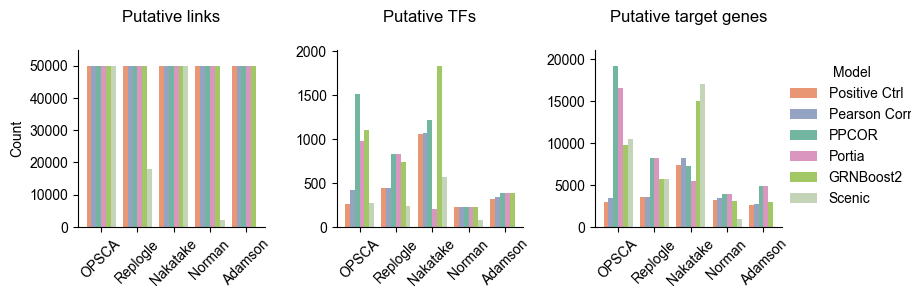

In [55]:
g = sns.catplot(
    data=topology_stats[topology_stats['Model'].isin(single_modality)],
    kind='bar',
    hue='Model',
    # hue_order=order_names,  # Specify the desired order of hue categories
    x='Dataset',
    y='Count',
    col='Type',
    # alpha=.5,
    palette=color_map_methods_all,
    sharey=False,
    height=2.7,  # Adjust plot size (smaller)
    aspect=1    # Adjust aspect ratio
)

# Remove x and y-axis labels
g.set_axis_labels("")

# Update column titles
for ax, col_name in zip(g.axes.flat, topology_stats['Type'].unique()):
    ax.set_title(col_name, fontsize=12, pad=20)  # Replace 'Type' with only the name

# Rotate x-axis labels
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=45)

# Add top and right edges
for ax in g.axes.flat:
    # ax.spines['top'].set_visible(True)
    # ax.spines['right'].set_visible(True)
    ax.margins(x=.05, y=.1)
    # ax.

# Customize legend
g._legend.set_title("Model")
g._legend.set_bbox_to_anchor((.98, 0.6))  # Adjust legend position

# plt.tight_layout()
plt.savefig(f"{results_folder}/figs/topology_stats_1.png", dpi=300, transparent=True, bbox_inches='tight')


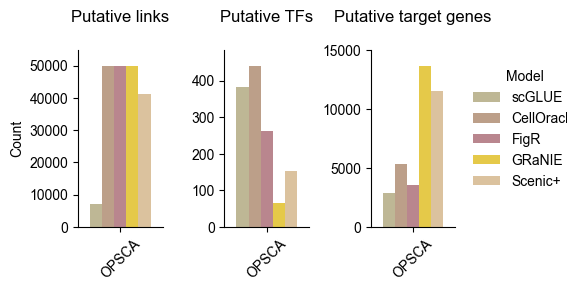

In [54]:
g = sns.catplot(
    data=topology_stats[~topology_stats['Model'].isin(single_modality)],
    kind='bar',
    hue='Model',
    # hue_order=order_names,  # Specify the desired order of hue categories
    x='Dataset',
    y='Count',
    col='Type',
    # alpha=.5,
    palette=color_map_methods_all,
    sharey=False,
    height=2.7,  # Adjust plot size (smaller)
    aspect=.6    # Adjust aspect ratio
)

# Remove x and y-axis labels
g.set_axis_labels("")

# Update column titles
for ax, col_name in zip(g.axes.flat, topology_stats['Type'].unique()):
    ax.set_title(col_name, fontsize=12, pad=20)  # Replace 'Type' with only the name

# Rotate x-axis labels
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=45)

# Add top and right edges
for ax in g.axes.flat:
    # ax.spines['top'].set_visible(True)
    # ax.spines['right'].set_visible(True)
    ax.margins(x=.2, y=.1)
    # ax.

# Customize legend
g._legend.set_title("Model")
g._legend.set_bbox_to_anchor((.98, 0.6))  # Adjust legend position

# plt.tight_layout()
plt.savefig(f"{results_folder}/figs/topology_stats_2.png", dpi=300, transparent=True, bbox_inches='tight')


NameError: name 'plot_stacked_bar' is not defined

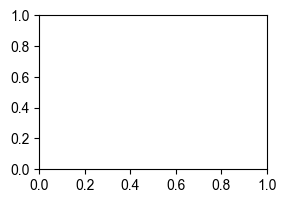

In [138]:
# order_names =[surragate_names[name] for name in ['positive_control', 'pearson_corr', 'ppcor', 'portia', 'grnboost2', 'scenic', 'scglue', 'celloracle', 'figr', 'granie', 'scenicplus']]

# fig = plt.figure(figsize=(10, 2))

# # Define the gridspec with uneven ratios for rows and columns
# gs = fig.add_gridspec(1, 3)

# ax = fig.add_subplot(gs[0, 0]) 
# plot_stacked_bar(topology_stats, ax, col='Putative links', rotation=90)
# ax.get_legend().remove()

# ax = fig.add_subplot(gs[0, 1]) 
# plot_stacked_bar(topology_stats, ax, col='Putative TFs', rotation=90)
# ax.get_legend().remove()
# ax.set_ylabel('')
# ax = fig.add_subplot(gs[0, 2]) 
# plot_stacked_bar(topology_stats, ax, col='Putative target genes', rotation=90)
# ax.set_ylabel('')
# plt.savefig(f"{results_folder}/figs/topology_stats.png", dpi=300, transparent=True, bbox_inches='tight')


## Network density 

In [44]:
# # tf gene: in degree

# fig, axes = plt.subplots(1, 2, figsize=(4.5, 2), sharey=True)

# plot_indegree_centrality({key:value for key, value in exp_objs_dict_dict.items() if key in ['op', 'nakatake']}, axes)
# axes[0].grid()
# axes[1].grid()

# axes[-1].legend(frameon=False, loc=(.3, .1))
# # plt.suptitle('In-degree centrality', y=1.1, fontsize=12, fontweight='bold')
# fig.savefig(f'{results_folder}/figs/centrality_in_short.png', dpi=300, transparent=True,  bbox_inches='tight')

In [143]:
# # tf gene: in degree

# fig, axes = plt.subplots(1, 5, figsize=(12, 2), sharey=True)

# plot_indegree_centrality(exp_objs_dict_dict, axes)
# # plt.suptitle('In-degree centrality', y=1.1, fontsize=12, fontweight='bold')
# fig.savefig(f'{results_folder}/figs/centrality_in.png', dpi=300, transparent=True,  bbox_inches='tight')

## Regulatory signs

In [66]:
if False:
    fig, axes = plt.subplots(1, len(datasets), figsize=(5*len(datasets), 4.5),   gridspec_kw={'width_ratios': [1.5, 1, 1, 1, 1]}  # Custom width ratios
    )
    for i, dataset in enumerate(datasets):
        ax = axes[i]
        exp_objs_dict = exp_objs_dict_dict[dataset]

        ratio_positive_negative_dict = {}

        for name, obj in exp_objs_dict.items():
            ratio_positive_negative_dict[name] = obj.stats['ratio_positive_negative']
        # ratio_positive_negative_dict[name] = obj.stats['ratio_positive_negative']

        data = ratio_positive_negative_dict
        models = list(data.keys())
        positive_r = [p for p in data.values()]
        negative_r = [1 - p for p in data.values()]


        df = pd.DataFrame({
            'Model': models * 2,  # Repeat model names for both Positive and Negative
            'Ratio': positive_r + negative_r,  # Concatenate positive and negative ratios
            'Regulatory Sign': ['Positive'] * len(models) + ['Negative'] * len(models)  # Label each as Positive or Negative
        })

        # Set Seaborn theme
        sns.set(style="whitegrid")  
        
        sns.barplot(x='Model', y='Ratio', hue='Regulatory Sign', data=df, width=.8,
                    palette=[list(color_map_methods.values())[1], list(color_map_methods.values())[0]], ax=ax)

        # Customize labels and ticks
        ax.set_ylabel('Ratio')
        ax.tick_params(axis='x', rotation=90)
        ax.margins(x=0.05)
        ax.set_xlabel('')
        ax.set_title(surragate_names[dataset], pad=20, fontsize=10, fontweight='bold')


        # Remove top and right spines
        sns.despine(ax=ax, top=True, right=True)

        ax.get_legend().remove()

        # Grid and legend
        # ax.grid(alpha=0.3, linestyle='--', linewidth=.5, color='grey')
        

    plt.suptitle('Regulatory sign', fontsize=12, fontweight='bold')
    plt.legend(frameon=False, loc=(1.1, .7))
    plt.tight_layout()
    # plt.savefig(f'{results_folder}/figs/regulatory_signs.png', dpi=300, transparent=True)


## Interactions 

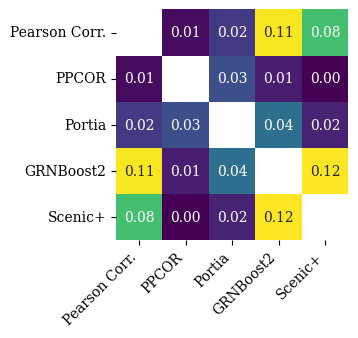

In [67]:
def plot_jaccard_similarity(dataset, ax):
    exp_objs_dict = exp_objs_dict_dict[dataset]
    exp_objs_dict = {key:value for key, value in exp_objs_dict.items() if key in ['Pearson Corr.', 'PPCOR', 'Portia', 'GRNBoost2', 'Scenic+']}
    nets = {}
    for name, obj in exp_objs_dict.items():
        nets[name] = obj.net
    _ = jaccard_similarity_net(nets, ax=ax)

    # ax.set_title(f'Jaccard similarity ({surragate_names[dataset]})', pad=20, fontsize=12, fontweight='bold')
    ax.set_title(f'', pad=20, fontsize=12, fontweight='bold')
    

for i, dataset in enumerate(['op']):
    
    if dataset == 'op':
        figsize=(3, 3)
    else:
        figsize=(5, 4)
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    plot_jaccard_similarity(dataset, ax)
    # plt.savefig(f'{results_folder}/figs/jaccard_similarity_{dataset}.png', dpi=300, transparent=True, bbox_inches='tight')


In [68]:
if False:
    # Create a set of all unique genes
    for i, dataset in enumerate(datasets):
        ax = axes[i]
        exp_objs_dict = exp_objs_dict_dict[dataset]

        shortlist_grns =   [surragate_names[key] for key in par['shortlist']]
        interaction_info = create_interaction_info({key:exp_objs_dict[key] for key in shortlist_grns})
        # fig = plot_interactions(interaction_info['links'], min_subset_size = 1000, min_degree=3, color_map=None)    
        # fig.savefig(f'{results_folder}/figs/links_interactions.png', dpi=300, transparent=True,  bbox_inches='tight')
        # fig = plot_interactions(interaction_info['source'], min_subset_size = 10, min_degree=2, color_map=None) 
        # fig.savefig(f'{results_folder}/figs/TFs_interactions.png', dpi=300, transparent=True, bbox_inches='tight')
        fig = plot_interactions(interaction_info['target'], min_subset_size = 10, min_degree=2, color_map=None) 
        # fig.savefig(f'{results_folder}/figs/targets_interactions.png', dpi=300, transparent=True, bbox_inches='tight')

# All plots

In [69]:
alphabets = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

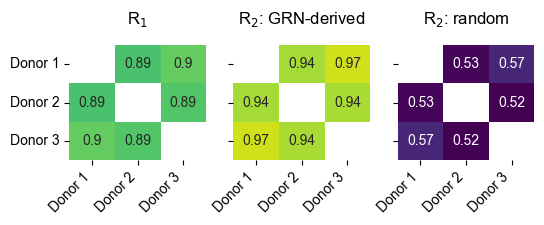

In [142]:
# Function to plot a heatmap with consistent color scaling
def plot_this_one(corr_matrix, ax, vmin, vmax):
    np.fill_diagonal(corr_matrix.values, np.nan)  # Optional: mask diagonal
    sns.heatmap(
        corr_matrix, 
        annot=True, 
        cmap="viridis", 
        cbar=False, 
        ax=ax, 
        vmin=vmin, 
        vmax=vmax
    )
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params('y', rotation=0)
    ax.tick_params(axis='x', rotation=45)
    for label in ax.get_xticklabels():
        label.set_ha('right')  # Set horizontal alignment to 'left'


# - reg2 
scores_store_table_reg2 = scores_store_all_reg2[scores_store_all_reg2['present']][['donor_id', 'r2score', 'model', 'gene']].pivot(
    index='donor_id', 
    values='r2score', 
    columns=['model', 'gene']
)
corr_matrix_grn_reg2 = scores_store_table_reg2.T.corr(method='spearman')

# - reg1 
scores_store_table_reg1 = scores_store_all_reg1.pivot_table(
    index='donor_id', 
    values='r2score', 
    columns=[col for col in scores_store_all_reg1.columns if col not in ['donor_id', 'r2score']]
).fillna(0)

# Calculate the Spearman correlation matrix
corr_matrix_reg1 = scores_store_table_reg1.T.corr(method='spearman')
np.fill_diagonal(corr_matrix_reg1.values, np.nan)


# Determine the global vmin and vmax for consistent color scale
vmin = 0.6
vmax = 1


# plot_this_one(corr_matrix_grn_reg2, ax, vmin, vmax)

fig, axes = plt.subplots(1, 3, figsize=(6, 1.5), sharey=True)

plot_this_one(corr_matrix_reg1, axes[0], vmin, vmax)
axes[0].set_title(r'R$_{1}$', pad=15)

plot_reg2_perfromance_similarity_donors(scores_store_all_reg2, axes[1:])


# plot_this_one(corr_matrix_grn_reg2, axes[1], vmin, vmax)
axes[1].set_title(r'R$_{2}$: GRN-derived', pad=15)
axes[2].set_title(r'R$_{2}$: random', pad=15)
plt.savefig(f'{results_folder}/figs/similaritys_donors.png', dpi=300, transparent=True, bbox_inches='tight')


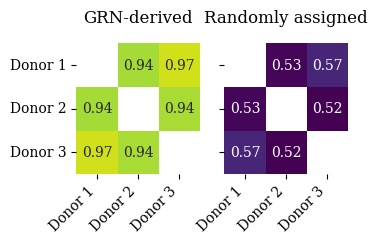

In [71]:
# - donor consistency
fig, axes = plt.subplots(1, 2, figsize=(3.5, 1.7), sharey=True)

plot_reg2_perfromance_similarity_donors(scores_store_all_reg2, axes=axes)

plt.savefig(f'{results_folder}/figs/similaritys_donors_reg2.png', dpi=300, transparent=True, bbox_inches='tight')



In [72]:
# # - consistency across models (heatmap)
# fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharey=True)

# ax = axes[0]
# plot_sample_wise_scores_similarity_models(scores_store_all_reg1, ax)

# ax = axes[1]
# plot_feature_importance_correlation_variation_across_models(feature_importance_all_reg1, ax)

# # plt.savefig(f'{results_folder}/figs/similaritys_models.png', dpi=300, transparent=True, bbox_inches='tight')

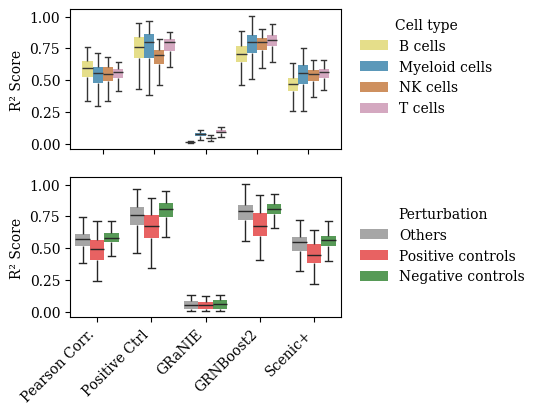

In [73]:
# - boxplot across models
fig, axes = plt.subplots(2, 1, figsize=(3.5, 4), sharey=True)

ax = axes[0]
plot_sample_wise_scores_segregated_by_celltypes(scores_store_all_reg1, ax)
ax.legend(loc=(1.05, .2), title="Cell type", frameon=False)
ax.set_xticklabels([])
ax = axes[1]
plot_sample_wise_scores_segregated_by_controls(scores_store_all_reg1, ax)
ax.legend(loc=(1.05, .2), title="Perturbation", frameon=False)

plt.savefig(f'{results_folder}/figs/boxplot_r2scores_tfactivation.png', dpi=300, transparent=True, bbox_inches='tight')


/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_57349/3636174929.py:15: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  sns.scatterplot(perturb_effect_all, x='STD fold change', y='Expression fold change', hue='perturbation_subset', alpha=.8, ax=ax, palette=sns.color_palette('Set2'))


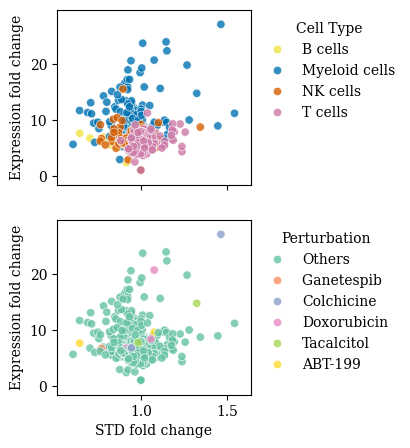

In [74]:
#- perturbation strength opsca
# - boxplot across models
fig, axes = plt.subplots(2, 1, figsize=(2.5, 5), sharex=True)

ax = axes[0]
plot_perturbation_strength_celltypes(perturb_effect_all, ax)
ax = axes[1]
plot_perturbation_strength_lowscored_samples(feature_importance_all_reg1, ax=ax)
ax.margins(x=0.1, y=0.1)

plt.savefig(f'{results_folder}/figs/opsca_perturbation_strength.png', dpi=300, transparent=True, bbox_inches='tight')


In [80]:
aaa

NameError: name 'aaa' is not defined

# CRE annoation

In [26]:
annotation_df = pd.read_csv(f'{task_grn_inference_dir}/resources/prior/peak_annotation.csv')
annotation_df.head()
for key, obj in exp_objs_dict.items():
    obj.annotate_peaks(annotation_df)

In [65]:
annotation_dict = {}
for name, obj in exp_objs_dict.items():
    if obj.peak_annot is not None:
        annotation_dict[name] = obj.peak_annot
peak_annotation_df = pd.DataFrame.from_dict(annotation_dict, orient='index')
threshold = 1 # remove below this raction
peak_annotation_df = peak_annotation_df.loc[:, (peak_annotation_df>threshold).sum(axis=0)!=0]
peak_annotation_df

,Promoter,Intron,Distal Intergenic,Exon,3' UTR,Downstream (<=300)
CellOracle,98.5,0.6,0.3,0.2,0.1,0.0
FigR,30.4,37.8,18.0,6.7,4.7,1.5
GRaNIE,66.2,15.8,10.4,4.0,2.3,0.9
Scenic+,35.1,34.4,17.3,6.8,4.4,1.2


In [115]:
peak_annotation_df = peak_annotation_df.reindex(['FigR', 'CellOracle', 'GRaNIE', 'Scenic+'])

/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_28270/1104589649.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if counts[j] == 0 or counts[j] < 4:  # Skip annotation for values less than 1%
/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_28270/1104589649.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(f'{counts[j]:.1f}%', xy=(x, y), xytext=(1.2*x, 1.2*y),


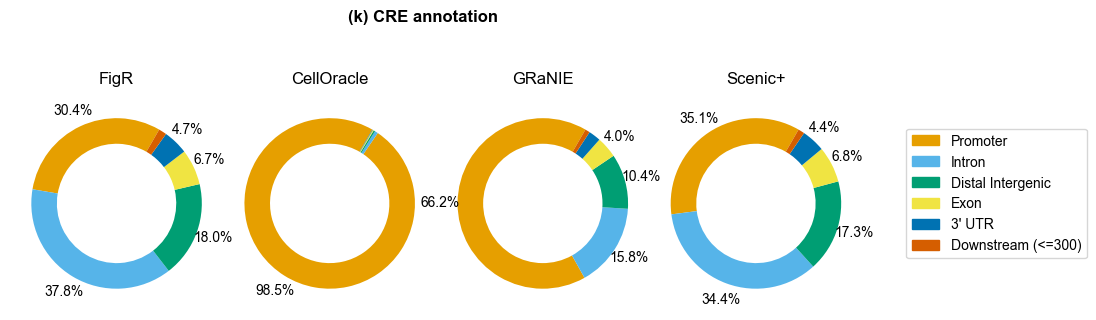

In [182]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np

# Create subplots with adjusted width ratios
fig, axes = plt.subplots(1, len(peak_annotation_df.index), figsize=(11, 4))
startangle = 60

# Iterate over pie charts
for i, (ax, idx) in enumerate(zip(axes, peak_annotation_df.index)):
    ax.set_title(idx, fontsize=12, pad=10)
    counts = peak_annotation_df.loc[idx]
    wedges, _ = ax.pie(counts, colors=colors_blind, wedgeprops=dict(width=0.3), startangle=startangle)

    for j, wedge in enumerate(wedges):
        if counts[j] == 0 or counts[j] < 4:  # Skip annotation for values less than 1%
            continue
        # Calculate angle and position for the annotation
        ang = (wedge.theta2 - wedge.theta1) / 2 + wedge.theta1
        x = np.cos(np.deg2rad(ang))
        y = np.sin(np.deg2rad(ang))
        ax.annotate(f'{counts[j]:.1f}%', xy=(x, y), xytext=(1.2*x, 1.2*y),
                    ha="center", va="center", fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.3", fc="none", ec="none"))

# Adjust spacing and add legend
plt.subplots_adjust(wspace=0)

# Create a single legend outside the pie charts
patches = [mpatches.Patch(color=color, label=name) for color, name in zip(colors_blind, peak_annotation_df.columns)]
fig.legend(handles=patches, loc='center right', bbox_to_anchor=(1.11, 0.52), fontsize=10)

fig.suptitle('(k) CRE annotation', fontsize=12, fontweight='bold')
# Save figure
fig.savefig(f'{results_folder}/figs/peak_annotation.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()